<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [3]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [6]:
#df=pd.read_excel("BG_Dataset/BG_sample27.xlsx")

In [7]:
# Colab
df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_sample4.xlsx")
#df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Sample46.csv")

In [8]:
df.shape

(1987, 14)

In [9]:
df.head(13)

색인 타임스탬프(YYYY-MM-DDThh:mm:ss) 이벤트 유형 이벤트 하위 유형                환자 정보  \
0    1                        NaN     이름       NaN                  sch   
1    2                        NaN      성       NaN                    s   
2    3                        NaN   생년월일       NaN  1990-01-01 00:00:00   
3    4                        NaN     장치       NaN                  NaN   
4    5                        NaN     경고        하락                  NaN   
5    6                        NaN     경고        높음                  NaN   
6    7                        NaN     경고        낮음                  NaN   
7    8                        NaN     경고     신호 손실                  NaN   
8    9                        NaN     경고        상승                  NaN   
9   10                        NaN     경고     매우 낮음                  NaN   
10  11        2019-07-30T12:09:57     교정       NaN                  NaN   
11  12        2019-07-30T12:10:11     교정       NaN                  NaN   
12  13        2019-07-30T17:30:00    인슐린       NaN                  NaN   

                   장치 정보 소스 장치 ID  포도당 값 (mg/dL)  인슐린 값(u)  탄수화물 값 (그램)  \
0                    NaN      NaN            NaN       NaN          NaN   
1                    NaN      NaN            NaN       NaN          NaN   
2                    NaN      NaN            NaN       NaN          NaN   
3   Dexcom G5 Mobile App  Android            NaN       NaN          NaN   
4                    NaN  Android            NaN       NaN          NaN   
5                    NaN  Android          400.0       NaN          NaN   
6                    NaN  Android           60.0       NaN          NaN   
7                    NaN  Android            NaN       NaN          NaN   
8                    NaN  Android            NaN       NaN          NaN   
9                    NaN  Android           55.0       NaN          NaN   
10                   NaN  Android           72.0       NaN          NaN   
11                   NaN  Android           72.0       NaN          NaN   
12                   NaN  Android            NaN       8.0          NaN   

   기간(hh:mm:ss)  포도당 변화율 (mg/dL/min)  트랜스미터 시간 (배장 정수) 트랜스미터 ID  
0           NaN                  NaN               NaN      NaN  
1           NaN                  NaN               NaN      NaN  
2           NaN                  NaN               NaN      NaN  
3           NaN                  NaN               NaN      NaN  
4           NaN                  3.0               NaN      NaN  
5           NaN                  NaN               NaN      NaN  
6           NaN                  NaN               NaN      NaN  
7      00:30:00                  NaN               NaN      NaN  
8           NaN                  3.0               NaN      NaN  
9           NaN                  NaN               NaN      NaN  
10          NaN                  NaN               NaN   40EPTP  
11          NaN                  NaN               NaN   40EPTP  
12          NaN                  NaN               NaN      NaN

In [10]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [11]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [12]:
df['Event'].value_counts()

EGV     1911
교정        33
인슐린       19
탄수화물      14
경고         6
장치         1
성          1
생년월일       1
이름         1
Name: Event, dtype: int64

In [13]:
df['Glucose'].value_counts()

155.0    30
116.0    25
118.0    22
117.0    22
120.0    22
         ..
315.0     1
281.0     1
245.0     1
310.0     1
400.0     1
Name: Glucose, Length: 263, dtype: int64

In [14]:
df.tail()

Timestamp Event  Glucose  Insulin  Meal
1982  2019-08-06T14:22:17   EGV    208.0      NaN   NaN
1983  2019-08-06T14:27:17   EGV    206.0      NaN   NaN
1984  2019-08-06T14:32:16   EGV    203.0      NaN   NaN
1985  2019-08-06T14:37:17   EGV    201.0      NaN   NaN
1986  2019-08-06T14:42:16   EGV    194.0      NaN   NaN

In [15]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

6.0     10
16.0     3
12.0     2
4.0      2
18.0     1
8.0      1
Name: Insulin, dtype: int64

In [16]:
# 식사 횟수
df['Meal'].value_counts()

250.0    13
200.0     1
Name: Meal, dtype: int64

In [17]:
df.head(15)

Timestamp Event  Glucose  Insulin   Meal
0                   NaN    이름      NaN      NaN    NaN
1                   NaN     성      NaN      NaN    NaN
2                   NaN  생년월일      NaN      NaN    NaN
3                   NaN    장치      NaN      NaN    NaN
4                   NaN    경고      NaN      NaN    NaN
5                   NaN    경고    400.0      NaN    NaN
6                   NaN    경고     60.0      NaN    NaN
7                   NaN    경고      NaN      NaN    NaN
8                   NaN    경고      NaN      NaN    NaN
9                   NaN    경고     55.0      NaN    NaN
10  2019-07-30T12:09:57    교정     72.0      NaN    NaN
11  2019-07-30T12:10:11    교정     72.0      NaN    NaN
12  2019-07-30T17:30:00   인슐린      NaN      8.0    NaN
13  2019-07-30T18:05:37    교정    176.0      NaN    NaN
14  2019-07-30T18:37:13  탄수화물      NaN      NaN  250.0

In [18]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [19]:
df.head(20)

Timestamp Event  Glucose  Insulin   Meal
10  2019-07-30T12:09:57    교정     72.0      NaN    NaN
11  2019-07-30T12:10:11    교정     72.0      NaN    NaN
12  2019-07-30T17:30:00   인슐린      NaN      8.0    NaN
13  2019-07-30T18:05:37    교정    176.0      NaN    NaN
14  2019-07-30T18:37:13  탄수화물      NaN      NaN  250.0
15  2019-07-30T18:45:02    교정    176.0      NaN    NaN
16  2019-07-30T18:47:51   EGV    180.0      NaN    NaN
17  2019-07-30T18:52:45   EGV    187.0      NaN    NaN
18  2019-07-30T18:57:45   EGV    189.0      NaN    NaN
19  2019-07-30T19:02:45   EGV    191.0      NaN    NaN
20  2019-07-30T19:07:44   EGV    196.0      NaN    NaN
21  2019-07-30T19:12:45   EGV    199.0      NaN    NaN
22  2019-07-30T19:17:45   EGV    203.0      NaN    NaN
23  2019-07-30T19:22:45   EGV    205.0      NaN    NaN
24  2019-07-30T19:27:45   EGV    208.0      NaN    NaN
25  2019-07-30T19:32:45   EGV    212.0      NaN    NaN
26  2019-07-30T19:37:45   EGV    213.0      NaN    NaN
27  2019-07-30T19:42:45   EGV    210.0      NaN    NaN
28  2019-07-30T19:47:45   EGV    212.0      NaN    NaN
29  2019-07-30T19:52:45   EGV    213.0      NaN    NaN

In [20]:
df.shape

(1977, 5)

In [21]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [22]:
df.head(15)

Timestamp Event  Glucose  Insulin   Meal
0   2019-07-30T12:09:57    교정     72.0      NaN    NaN
1   2019-07-30T12:10:11    교정     72.0      NaN    NaN
2   2019-07-30T17:30:00   인슐린      NaN      8.0    NaN
3   2019-07-30T18:05:37    교정    176.0      NaN    NaN
4   2019-07-30T18:37:13  탄수화물      NaN      NaN  250.0
5   2019-07-30T18:45:02    교정    176.0      NaN    NaN
6   2019-07-30T18:47:51   EGV    180.0      NaN    NaN
7   2019-07-30T18:52:45   EGV    187.0      NaN    NaN
8   2019-07-30T18:57:45   EGV    189.0      NaN    NaN
9   2019-07-30T19:02:45   EGV    191.0      NaN    NaN
10  2019-07-30T19:07:44   EGV    196.0      NaN    NaN
11  2019-07-30T19:12:45   EGV    199.0      NaN    NaN
12  2019-07-30T19:17:45   EGV    203.0      NaN    NaN
13  2019-07-30T19:22:45   EGV    205.0      NaN    NaN
14  2019-07-30T19:27:45   EGV    208.0      NaN    NaN

In [23]:
df.shape

(1977, 5)

In [24]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [25]:
def isNaN(num):
    return num==num

In [26]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [27]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [28]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [29]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [30]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [31]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [32]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [33]:
glucose_count_high(df,'Glucose')

높음 :  0


In [34]:
print('높음 개수 :',len(high_list))

높음 개수 : 0


In [35]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [36]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [37]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [38]:
low_list

[]

In [39]:
calibration_count_low(df,'Event')

교정 :  33


In [40]:
calib_list

[0,
 1,
 3,
 5,
 33,
 143,
 326,
 553,
 596,
 615,
 730,
 731,
 775,
 777,
 853,
 915,
 1033,
 1034,
 1074,
 1156,
 1222,
 1325,
 1378,
 1454,
 1516,
 1628,
 1668,
 1748,
 1813,
 1870,
 1871,
 1909,
 1910]

In [41]:
insul_count(df,'Insulin')

인슐린 :  19


In [42]:
insulin_list

[2,
 34,
 446,
 507,
 621,
 869,
 920,
 1106,
 1168,
 1218,
 1343,
 1405,
 1467,
 1518,
 1651,
 1704,
 1776,
 1816,
 1947]

In [43]:
meal_count(df,'Meal')

식사 횟수 :  14


In [44]:
meal_list

[4, 450, 514, 576, 759, 831, 882, 1056, 1112, 1181, 1256, 1379, 1480, 1783]

In [45]:
df['Insulin'].value_counts()

6.0     10
16.0     3
12.0     2
4.0      2
18.0     1
8.0      1
Name: Insulin, dtype: int64

In [46]:
df['Meal'].value_counts()

250.0    13
200.0     1
Name: Meal, dtype: int64

In [47]:
#isNaN(df['Glucose'][14])

In [48]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [49]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [50]:
import math
math.isnan(df['Glucose'][14])

False

In [51]:
insulin_list

[2,
 34,
 446,
 507,
 621,
 869,
 920,
 1106,
 1168,
 1218,
 1343,
 1405,
 1467,
 1518,
 1651,
 1704,
 1776,
 1816,
 1947]

In [52]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [53]:
insulin_list

[2,
 34,
 446,
 507,
 621,
 869,
 920,
 1106,
 1168,
 1218,
 1343,
 1405,
 1467,
 1518,
 1651,
 1704,
 1776,
 1816,
 1947,
 576,
 1056,
 450,
 514,
 4,
 1379,
 1256,
 1480,
 759,
 882,
 1783,
 1112,
 1181,
 831]

In [54]:
df=df.drop(insulin_list)

In [55]:
df[10:20]

Timestamp Event  Glucose  Insulin  Meal
12  2019-07-30T19:17:45   EGV    203.0      NaN   NaN
13  2019-07-30T19:22:45   EGV    205.0      NaN   NaN
14  2019-07-30T19:27:45   EGV    208.0      NaN   NaN
15  2019-07-30T19:32:45   EGV    212.0      NaN   NaN
16  2019-07-30T19:37:45   EGV    213.0      NaN   NaN
17  2019-07-30T19:42:45   EGV    210.0      NaN   NaN
18  2019-07-30T19:47:45   EGV    212.0      NaN   NaN
19  2019-07-30T19:52:45   EGV    213.0      NaN   NaN
20  2019-07-30T19:57:45   EGV    215.0      NaN   NaN
21  2019-07-30T20:02:45   EGV    214.0      NaN   NaN

In [56]:
df['Glucose'].unique()

array([ 72., 176., 180., 187., 189., 191., 196., 199., 203., 205., 208.,
       212., 213., 210., 215., 214., 204., 206., 202., 200., 198., 193.,
       177., 192., 181., 178., 179., 175., 173., 172., 170., 169., 168.,
       165., 162., 160., 159., 158., 157., 156., 155., 152., 150., 148.,
       145., 143., 141., 138., 136., 134., 133., 132., 131., 129., 128.,
       127., 125., 123., 121., 119., 117., 115., 113., 111., 110., 108.,
       107., 106., 105., 104., 103., 102., 101.,  98.,  96.,  95.,  93.,
        92.,  91.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  80.,  79.,
        78.,  75.,  74.,  73.,  71.,  69.,  67.,  66.,  65.,  64.,  63.,
        62.,  61.,  60.,  59.,  58.,  57.,  55.,  54.,  53.,  90.,  89.,
        77.,  99., 100.,  56.,  94.,  97., 112., 120., 140., 185., 190.,
       188., 186., 183., 182., 174., 171., 166., 164., 163., 161., 154.,
       147., 144., 142., 139., 137., 135., 130., 126., 122., 118., 124.,
       184., 194., 211., 217., 220., 223., 227., 23

In [57]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1925
Meal         1930
dtype: int64

In [58]:
df['Event'].value_counts()

EGV    1911
교정       33
Name: Event, dtype: int64

In [59]:
bg = df['Glucose']

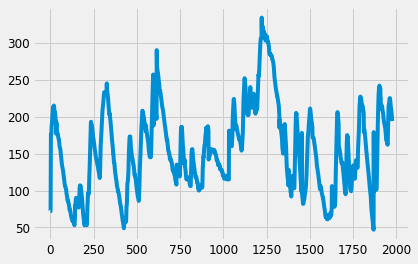

In [60]:
bg.plot()

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [61]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [62]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [63]:
fix_glucose_low(df,'Glucose')

In [64]:
fix_glucose(df,'Glucose')

In [65]:
df['Glucose'].value_counts()

155.0    30
116.0    25
118.0    22
117.0    22
120.0    22
         ..
297.0     1
265.0     1
316.0     1
300.0     1
277.0     1
Name: Glucose, Length: 262, dtype: int64

In [66]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1925
Meal         1930
dtype: int64

In [67]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [68]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [69]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [70]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [71]:
new_meal_list

[3, 446, 508, 569, 750, 821, 870, 1042, 1096, 1163, 1236, 1357, 1455, 1753]

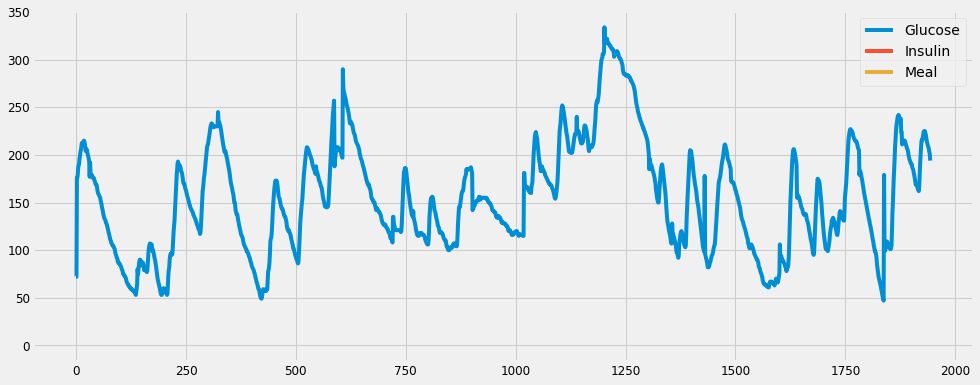

In [72]:
df.plot(figsize=(15,6))
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


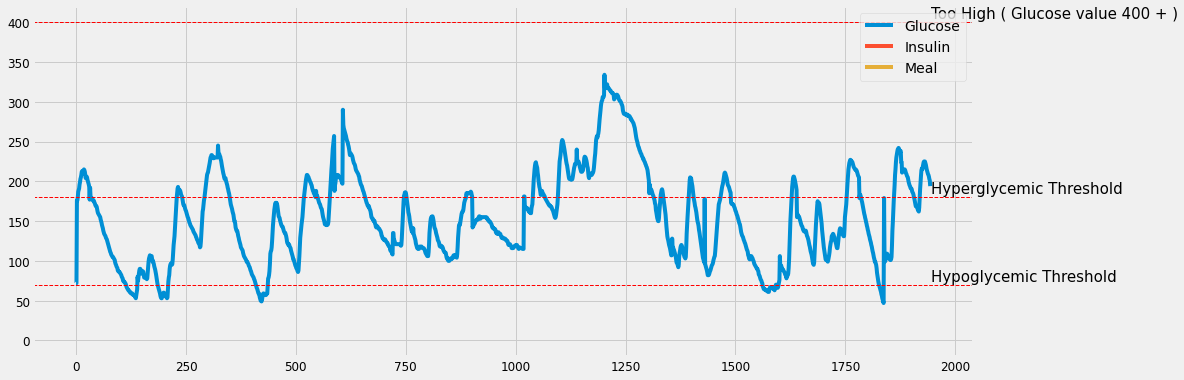

In [73]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [74]:
#df.drop(0,inplace=True)

In [75]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [76]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [77]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [78]:
#interpolate_glucose(df,'Glucose')

In [79]:
#meal

In [80]:
#insul

In [81]:
df['Glucose'].isnull().sum()

0

In [82]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [83]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [84]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [85]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


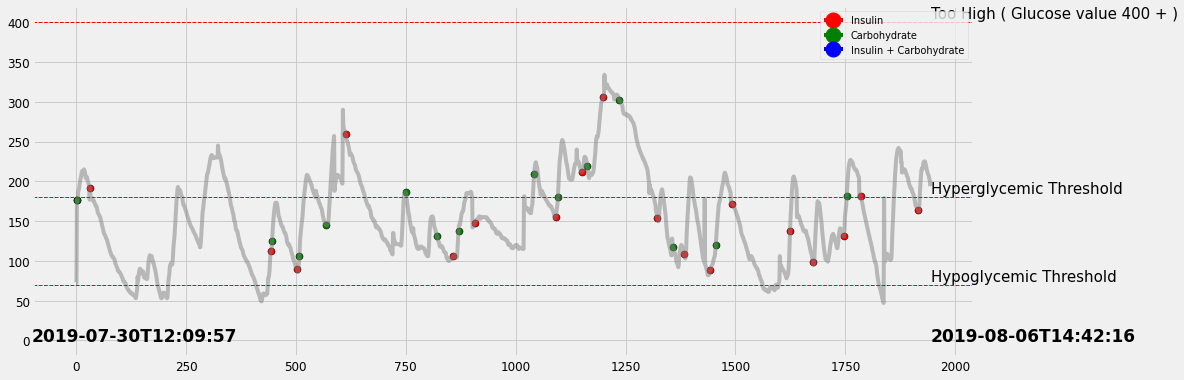

In [86]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [87]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [88]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [89]:
df[1900:1950]

Timestamp Event  Glucose  Insulin  Meal
1900  2019-08-06T11:07:17   EGV    191.0      0.0   0.0
1901  2019-08-06T11:12:16   EGV    190.0      0.0   0.0
1902  2019-08-06T11:17:17   EGV    187.0      0.0   0.0
1903  2019-08-06T11:22:16   EGV    186.0      0.0   0.0
1904  2019-08-06T11:27:16   EGV    185.0      0.0   0.0
1905  2019-08-06T11:32:17   EGV    183.0      0.0   0.0
1906  2019-08-06T11:37:17   EGV    180.0      0.0   0.0
1907  2019-08-06T11:42:17   EGV    178.0      0.0   0.0
1908  2019-08-06T11:47:17   EGV    175.0      0.0   0.0
1909  2019-08-06T11:52:16   EGV    172.0      0.0   0.0
1910  2019-08-06T11:57:17   EGV    169.0      0.0   0.0
1911  2019-08-06T12:02:16   EGV    169.0      0.0   0.0
1912  2019-08-06T12:07:16   EGV    168.0      0.0   0.0
1913  2019-08-06T12:12:17   EGV    167.0      0.0   0.0
1914  2019-08-06T12:17:16   EGV    166.0      0.0   0.0
1915  2019-08-06T12:22:17   EGV    164.0      1.0   0.0
1916  2019-08-06T12:27:17   EGV    163.0      0.0   0.0
1917  2019-08-06T12:32:17   EGV    162.0      0.0   0.0
1918  2019-08-06T12:37:17   EGV    167.0      0.0   0.0
1919  2019-08-06T12:42:16   EGV    180.0      0.0   0.0
1920  2019-08-06T12:47:16   EGV    190.0      0.0   0.0
1921  2019-08-06T12:52:17   EGV    199.0      0.0   0.0
1922  2019-08-06T12:57:16   EGV    207.0      0.0   0.0
1923  2019-08-06T13:02:17   EGV    214.0      0.0   0.0
1924  2019-08-06T13:07:17   EGV    216.0      0.0   0.0
1925  2019-08-06T13:12:16   EGV    215.0      0.0   0.0
1926  2019-08-06T13:17:17   EGV    218.0      0.0   0.0
1927  2019-08-06T13:22:16   EGV    221.0      0.0   0.0
1928  2019-08-06T13:27:16   EGV    224.0      0.0   0.0
1929  2019-08-06T13:32:17   EGV    225.0      0.0   0.0
1930  2019-08-06T13:37:16   EGV    225.0      0.0   0.0
1931  2019-08-06T13:42:16   EGV    225.0      0.0   0.0
1932  2019-08-06T13:47:17   EGV    223.0      0.0   0.0
1933  2019-08-06T13:52:17   EGV    221.0      0.0   0.0
1934  2019-08-06T13:57:17   EGV    218.0      0.0   0.0
1935  2019-08-06T14:02:17   EGV    215.0      0.0   0.0
1936  2019-08-06T14:07:17   EGV    213.0      0.0   0.0
1937  2019-08-06T14:12:17   EGV    211.0      0.0   0.0
1938  2019-08-06T14:17:17   EGV    209.0      0.0   0.0
1939  2019-08-06T14:22:17   EGV    208.0      0.0   0.0
1940  2019-08-06T14:27:17   EGV    206.0      0.0   0.0
1941  2019-08-06T14:32:16   EGV    203.0      0.0   0.0
1942  2019-08-06T14:37:17   EGV    201.0      0.0   0.0
1943  2019-08-06T14:42:16   EGV    194.0      0.0   0.0

In [90]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [91]:
fix_glucose_value(df,'Glucose')

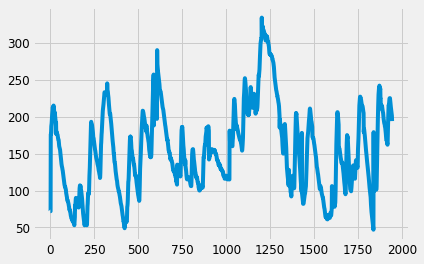

In [92]:
bg = df['Glucose']
bg.plot()

In [95]:
from sklearn.model_selection import train_test_split
X, Y = train_test_split(df['Glucose'],test_size=0.3,shuffle=False)

In [163]:
decomposition = sm.tsa.seasonal_decompose(df.Glucose, model='additive')

AttributeError: ignored

In [97]:
Y.shape

(584,)

In [157]:
from pmdarima import auto_arima 
stepwise_fit = auto_arima(df['Glucose'])           # set to stepwise 
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1944
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -6487.485
Date:                Mon, 15 Mar 2021   AIC                          12986.969
Time:                        06:32:08   BIC                          13020.401
Sample:                             0   HQIC                         12999.263
                               - 1944                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6697      0.158     10.585      0.000       1.361       1.979
ar.L2         -0.7364      0.130     -5.677      0.000      -0.991      -0.482
ma.L1         -1.7311      0.160    -10.827      0.000      -2.044      -1.418
ma.L2          0.9669      0.143      6.784      0.000       0.688       1.246
ma.L3         -0.1300      0.036     -3.597      0.000      -0.201      -0.059
sigma2        46.5152      0.224    207.697      0.000      46.076      46.954
===================================================================================
Ljung-Box (Q):                       21.80   Jarque-Bera (JB):           1771504.89
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             6.44
Prob(H) (two-sided):                  0.00   Kurtosis:                       150.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
model = SARIMAX(X,  
                order = (2, 1, 3)) 

In [159]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                Glucose   No. Observations:                 1360
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -4304.588
Date:                Mon, 15 Mar 2021   AIC                           8621.176
Time:                        06:33:23   BIC                           8652.463
Sample:                             0   HQIC                          8632.889
                               - 1360                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6808      0.366      4.588      0.000       0.963       2.399
ar.L2         -0.7262      0.309     -2.350      0.019      -1.332      -0.120
ma.L1         -1.6127      0.369     -4.369      0.000      -2.336      -0.889
ma.L2          0.7597      0.288      2.637      0.008       0.195       1.324
ma.L3         -0.0621      0.044     -1.427      0.154      -0.147       0.023
sigma2        33.0137      0.217    152.345      0.000      32.589      33.438
===================================================================================
Ljung-Box (Q):                       60.29   Jarque-Bera (JB):           1326171.07
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             6.73
Prob(H) (two-sided):                  0.00   Kurtosis:                       155.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
start = len(X)
end = len(Y) + len(X) -1
predict = result.predict(start,end,typ='levels').rename("predictions")

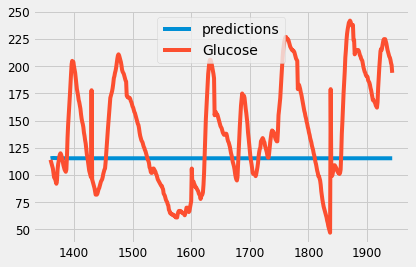

In [161]:
predict.plot(legend=True)
Y.plot(legend=True)

In [118]:
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(df['Glucose'])

In [116]:
test_result

(-4.416231028764198,
 0.00027780329098080843,
 6,
 1937,
 {'1%': -3.4337304786522114,
  '10%': -2.5675649665362372,
  '5%': -2.8630332867971835},
 12592.186163405153)

In [164]:
def adfuller_test(Glucose):
    result=adfuller(Glucose,autolag='AIC')
    print(result)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
      print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Glucose'])

(-4.416231028764198, 0.00027780329098080843, 6, 1937, {'1%': -3.4337304786522114, '5%': -2.8630332867971835, '10%': -2.5675649665362372}, 12592.186163405153)
ADF Test Statistic : -4.416231028764198
p-value : 0.00027780329098080843
#Lags Used : 6
Number of Observations : 1937
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [167]:
ts_temp_log = np.log(df['Glucose'])
ts_temp_log

0       4.276666
1       4.276666
2       5.170484
3       5.170484
4       5.192957
          ...   
1939    5.337538
1940    5.327876
1941    5.313206
1942    5.303305
1943    5.267858
Name: Glucose, Length: 1944, dtype: float64

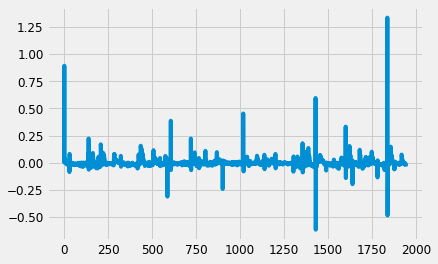

In [172]:
ts_temp_log_diff = np.diff(ts_temp_log)
plt.plot(ts_temp_log_diff)

In [129]:
df['Glucose First Difference'] = df['Glucose'] - df['Glucose'].shift(1)
df['Seasonal First Difference']=df['Glucose']-df['Glucose'].shift(6)
df.head()

Timestamp Event  Glucose  Insulin  Meal  \
0  2019-07-30T12:09:57    교정     72.0      0.0   0.0   
1  2019-07-30T12:10:11    교정     72.0      0.0   0.0   
2  2019-07-30T18:05:37    교정    176.0      1.0   0.0   
3  2019-07-30T18:45:02    교정    176.0      0.0   1.0   
4  2019-07-30T18:47:51   EGV    180.0      0.0   0.0   

   Glucose First Difference  Seasonal First Difference  
0                       NaN                        NaN  
1                       0.0                        NaN  
2                     104.0                        NaN  
3                       0.0                        NaN  
4                       4.0                        NaN

In [134]:
adfuller_test(df['Seasonal First Difference'].dropna())

(-7.855736707615101, 5.449225363279811e-12, 24, 1913, {'1%': -3.433772946369569, '5%': -2.8630520356606137, '10%': -2.567574949489954}, 12879.880445319912)
ADF Test Statistic : -7.855736707615101
p-value : 5.449225363279811e-12
#Lags Used : 24
Number of Observations : 1913
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


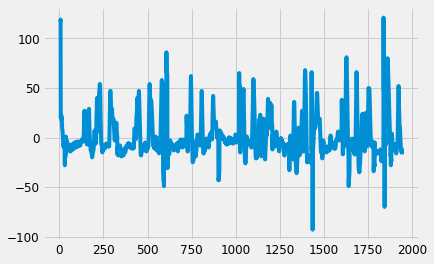

In [135]:
df['Seasonal First Difference'].plot()

In [133]:
df.head()

Timestamp Event  Glucose  Insulin  Meal  \
0  2019-07-30T12:09:57    교정     72.0      0.0   0.0   
1  2019-07-30T12:10:11    교정     72.0      0.0   0.0   
2  2019-07-30T18:05:37    교정    176.0      1.0   0.0   
3  2019-07-30T18:45:02    교정    176.0      0.0   1.0   
4  2019-07-30T18:47:51   EGV    180.0      0.0   0.0   

   Glucose First Difference  Seasonal First Difference  
0                       NaN                        NaN  
1                       0.0                        NaN  
2                     104.0                        NaN  
3                       0.0                        NaN  
4                       4.0                        NaN

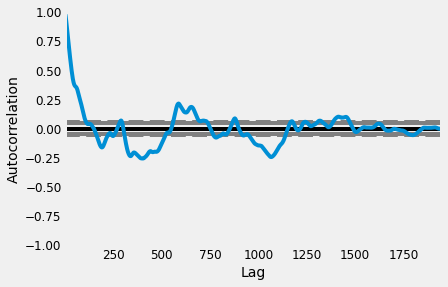

In [136]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Glucose'])
plt.show()

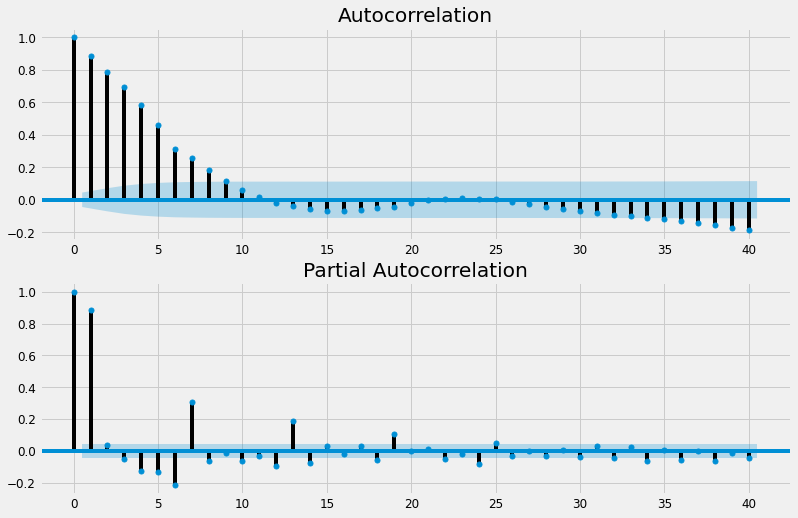

In [137]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [138]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['Glucose'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Glucose   No. Observations:                 1943
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6526.294
Method:                       css-mle   S.D. of innovations              6.958
Date:                Mon, 15 Mar 2021   AIC                          13060.587
Time:                        06:09:10   BIC                          13082.875
Sample:                             1   HQIC                         13068.783
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0934      0.277      0.337      0.736      -0.450       0.637
ar.L1.D.Glucose     0.8924      0.025     36.329      0.000       0.844       0.941
ma.L1.D.Glucose    -0.8106      0.030    -27.388      0.000      -0.869      -0.753
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1206           +0.0000j            1.1206            0.0000
MA.1            1.2337           +0.0000j            1.2337            0.0000
-----------------------------------------------------------------------------
"""

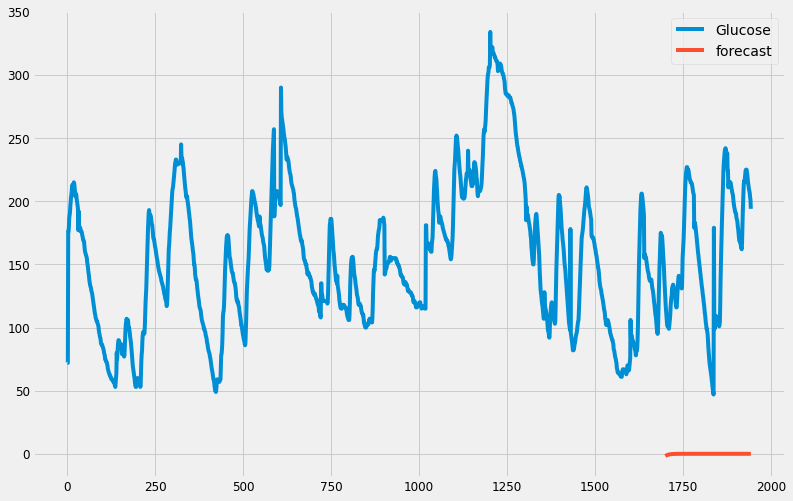

In [140]:
df['forecast']=model_fit.predict(start=1700,end=2000,dynamic=True)
df[['Glucose','forecast']].plot(figsize=(12,8))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


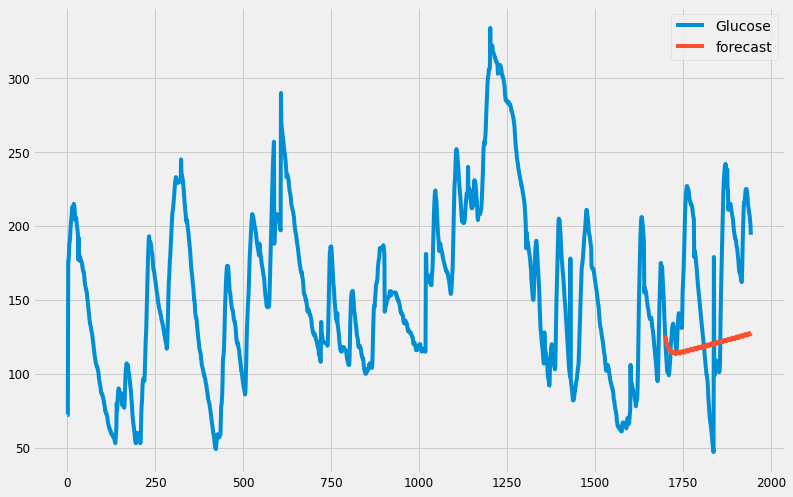

In [142]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Glucose'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=1700,end=2000,dynamic=True)
df[['Glucose','forecast']].plot(figsize=(12,8))

## ARIMA Parameter setting

In [101]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 5.5MB/s 
     |████████████████████████████████| 9.5MB 3.0MB/s 
     |████████████████████████████████| 2.1MB 50.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
stepwise_model = auto_arima(X, start_p=1, start_q=1,
                           max_p=3, max_q=3,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=8.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=9400.079, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=9047.019, Time=0.85 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=8.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=9374.760, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8946.067, Time=2.38 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=37.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=11.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=8973.872, Time=1.81 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8908.043, Time=3.68 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=9014.839, Time=1.51 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=30.55 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=13.79 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=8883.786, Time=3.41 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=89

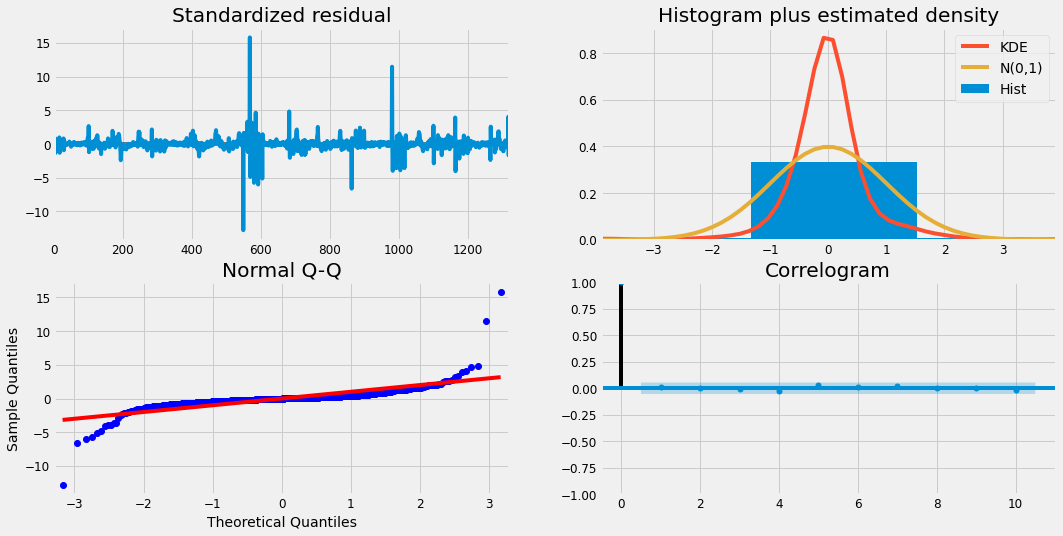

In [103]:
SARIMAMonth = sm.tsa.statespace.SARIMAX(X, order=(2, 1, 2), seasonal_order=(2, 1, 0, 12) ,enforce_stationarity=False,enforce_invertibility=False)

SARIMA_results_month = SARIMAMonth.fit()

SARIMA_results_month.plot_diagnostics(figsize=(16, 8))
plt.show()

nan


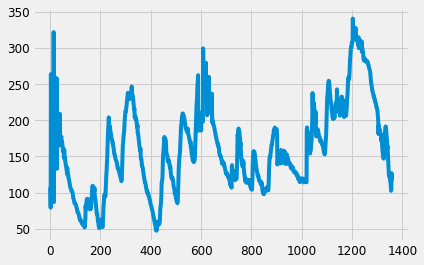

In [114]:
# 2017년 12개월 데이터로 예측
SARIMA_predict_month_1 = SARIMA_results_month.predict()

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임

# RMSE를 살펴 봄
RMSE_Month_Seasonal_ARIMA  = np.mean(np.sqrt((SARIMA_predict_month_1 - Y) ** 2)) 
print(RMSE_Month_Seasonal_ARIMA)
#-> 12190.886296802802

# test 데이터와 예측 결과치를 비교
SARIMA_predict_month_1[1:].plot()

In [111]:
SARIMA_predict_month_1

0         0.000000
1       107.406103
2        79.255208
3       263.704063
4       188.306370
           ...    
1355    102.480549
1356    104.438037
1357    126.819275
1358    116.289756
1359    116.266756
Length: 1360, dtype: float64

In [112]:
X.shape

(1360,)

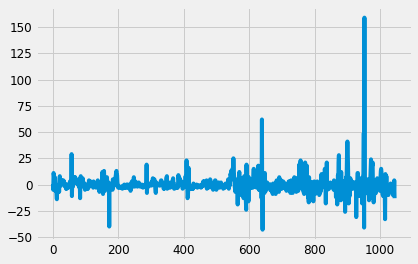

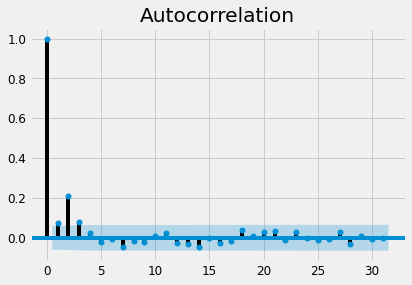

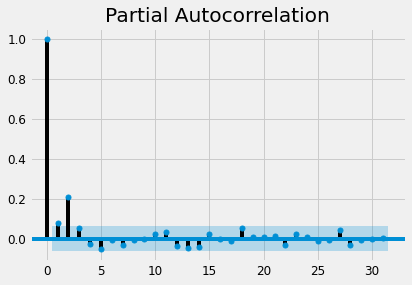

In [ ]:
diff_1 = bg.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

## Build Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(bg,order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True,disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.Glucose   No. Observations:                 1044
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3741.798
Method:                       css-mle   S.D. of innovations              8.716
Date:                Wed, 03 Feb 2021   AIC                           7489.597
Time:                        04:21:31   BIC                           7504.449
Sample:                             1   HQIC                          7495.230
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0578      0.284      0.203      0.839      -0.499       0.615
ma.L1.D.Glucose     0.0540      0.026      2.063      0.039       0.003       0.105
                                

In [ ]:
model2 = ARIMA(bg,order=(0,1,1))
model2_fit = model.fit(trend='nc',full_output=True,disp=1)
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.Glucose   No. Observations:                 1044
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3741.819
Method:                       css-mle   S.D. of innovations              8.716
Date:                Wed, 03 Feb 2021   AIC                           7487.638
Time:                        04:21:31   BIC                           7497.540
Sample:                             1   HQIC                          7491.394
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ma.L1.D.Glucose     0.0540      0.026      2.064      0.039       0.003       0.105
                                    Roots                                    
                  Real          Imagin

## Prediction

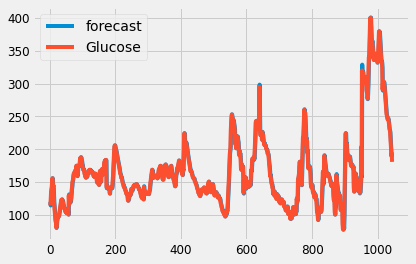

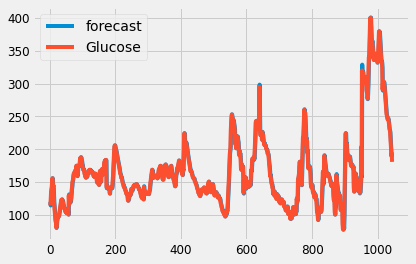

In [ ]:
model2_fit.plot_predict()

In [ ]:
fore = model2_fit.forecast(steps=6)

In [ ]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['Glucose'])

1. ADF :  -3.5531438592257136
2. P-Value :  0.006722651517198002
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 1041
5. Critical Values :
	 1% :  -3.436647308529461
	 5% :  -2.864320407484321
	 10% :  -2.568250401889486


In [ ]:
!pip3 install pmdarima

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Glucose'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7443.681, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7491.857, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7487.857, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7489.597, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7489.904, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7441.925, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7448.071, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7468.013, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7443.750, Time=0.76 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7442.635, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7444.876, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7444.279, Time=2.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7439.946, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7446.099, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [ ]:
diff_1 = df['Glucose'].diff(periods=1).iloc[1:]

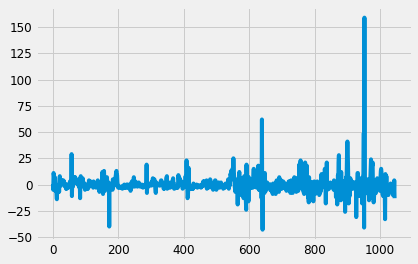

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df['Glucose'],test_size=0.3,shuffle=False)

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Glucose'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7443.681, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7491.857, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7487.857, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7489.597, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7489.904, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7441.925, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7448.071, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7468.013, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7443.750, Time=0.77 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7442.635, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7444.876, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7444.279, Time=2.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7439.946, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7446.099, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [ ]:
print(train.shape,test.shape)

(730,) (314,)


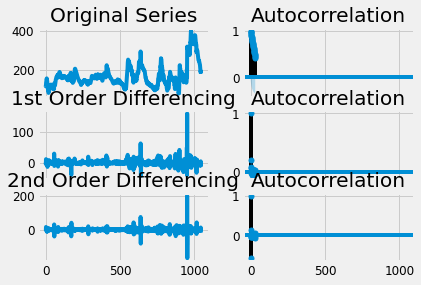

In [ ]:
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['Glucose']); axes[0, 0].set_title('Original Series')
plot_acf(df['Glucose'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Glucose'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Glucose'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Glucose'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Glucose'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
from pmdarima.arima.utils import ndiffs
y = df['Glucose']

## Adf Test
print(ndiffs(y, test='adf'))  # 2

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
print(ndiffs(y, test='pp'))  # 2

0
1
0


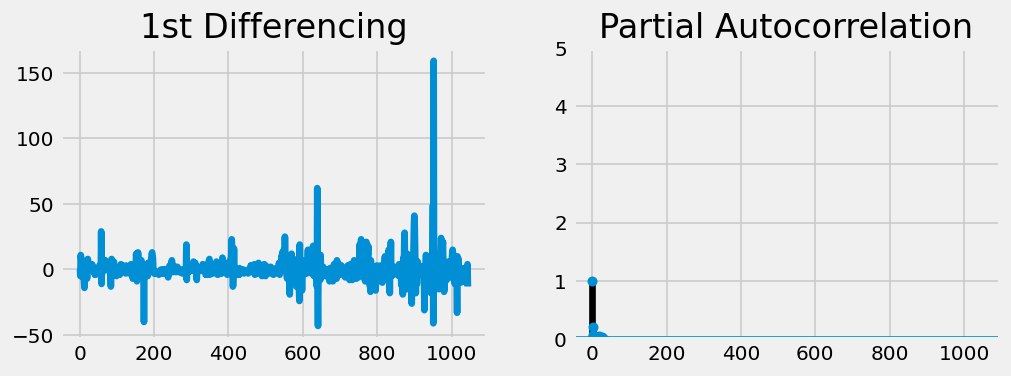

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['Glucose'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df['Glucose'].diff().dropna(), ax=axes[1])

plt.show()

                             ARIMA Model Results                              
Dep. Variable:              D.Glucose   No. Observations:                  729
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2299.517
Method:                       css-mle   S.D. of innovations              5.649
Date:                Wed, 03 Feb 2021   AIC                           4609.034
Time:                        04:55:00   BIC                           4631.992
Sample:                             1   HQIC                          4617.892
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0010      0.001     -0.670      0.503      -0.004       0.002
ar.L1.D.Glucose     0.7202      0.148      4.860      0.000       0.430       1.011
ma.L1.D.Glucose    -1.5753      

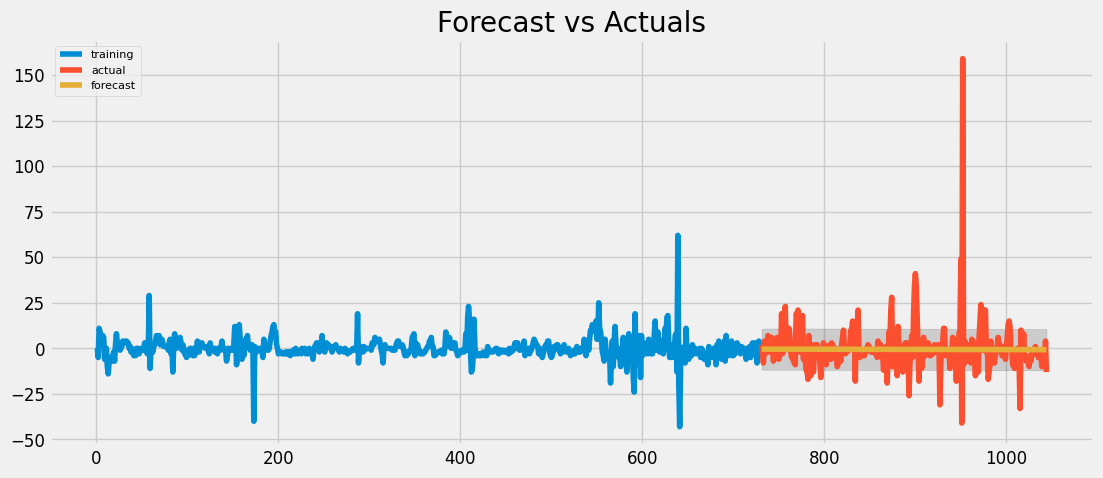

In [ ]:
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(314, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
model = ARIMA(train,order=(1,0,2))
model_fit = model.fit(trend='nc',full_output=True,disp=True)
model_fit.summary(
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                Glucose   No. Observations:                  731
Model:                     ARMA(1, 2)   Log Likelihood               -2308.556
Method:                       css-mle   S.D. of innovations              5.668
Date:                Wed, 03 Feb 2021   AIC                           4625.112
Time:                        04:59:29   BIC                           4643.489
Sample:                             0   HQIC                          4632.202
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.Glucose     0.9987      0.001    839.940      0.000       0.996       1.001
ma.L1.Glucose     0.1763      0.037      4.733      0.000       0.103       0.249
ma.L2.Glucose     0.0288      0.037      0.788      0.431      -0.043       0.101
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           +0.0000j            1.0013            0.0000
MA.1           -3.0568           -5.0326j            5.8882           -0.3369
MA.2           -3.0568           +5.0326j            5.8882            0.3369
-----------------------------------------------------------------------------
"""

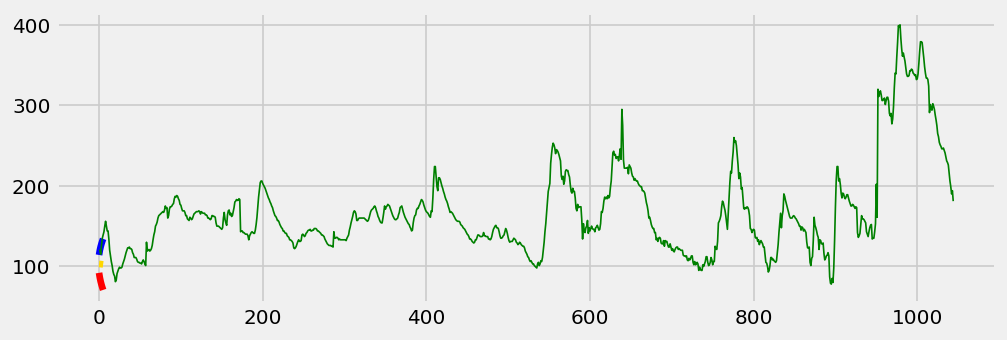

In [ ]:
forecast_data = model_fit.forecast(steps=6) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
test_file_path = '../data/market-price-test.csv'
#bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y =y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)
    
plt.plot(pred_y, color="gold",) # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green",linewidth=1) # 실제 가격 그래프입니다.

In [ ]:
pip install fbprophet

In [ ]:
df=df.rename({'Timestamp':'ds','Glucose':'y'},axis='columns')

In [ ]:
cols = ['Event', 'Insulin', 'Meal']
df.drop(cols, axis=1, inplace=True)

In [ ]:
df.head()

ds      y
0  2019-05-07T16:07:41  120.0
1  2019-05-07T16:07:54  120.0
2  2019-05-07T16:12:56  115.0
3  2019-05-07T16:17:47  126.0
4  2019-05-07T16:22:47  135.0

In [ ]:
df['cap']= 400
df['floor'] = 60 

In [ ]:
m = Prophet(growth='logistic',changepoint_prior_scale=0.5))
m.fit(df)

SyntaxError: ignored

In [ ]:
future = m.make_future_dataframe(periods=3)
future.tail()

ds
1041 2019-05-11 23:47:34
1042 2019-05-11 23:52:33
1043 2019-05-11 23:57:33
1044 2019-05-12 00:02:33
1045 2019-05-13 00:02:33

In [ ]:
future['cap'] = 400
future['floor'] = 60

In [ ]:
forecast = m.predict(future)
forecast.tail()

ds       trend  cap  floor  yhat_lower  yhat_upper  \
1041 2019-05-11 23:47:34  291.073680  400     60  240.654887  327.057384   
1042 2019-05-11 23:52:33  291.350051  400     60  241.204610  332.387334   
1043 2019-05-11 23:57:33  291.626973  400     60  237.778097  328.997954   
1044 2019-05-12 00:02:33  291.903519  400     60  245.393711  328.620784   
1045 2019-05-13 00:02:33  353.515014  400     60  303.238851  393.187258   

      trend_lower  trend_upper  additive_terms  additive_terms_lower  \
1041   291.073680   291.073680       -5.426440             -5.426440   
1042   291.350051   291.350051       -4.956455             -4.956455   
1043   291.626973   291.626973       -4.391392             -4.391392   
1044   291.903519   291.903519       -3.739379             -3.739379   
1045   348.926597   357.265553       -3.739379             -3.739379   

      additive_terms_upper     daily  daily_lower  daily_upper  \
1041             -5.426440 -5.426440    -5.426440    -5.426440   
1042             -4.956455 -4.956455    -4.956455    -4.956455   
1043             -4.391392 -4.391392    -4.391392    -4.391392   
1044             -3.739379 -3.739379    -3.739379    -3.739379   
1045             -3.739379 -3.739379    -3.739379    -3.739379   

      multiplicative_terms  multiplicative_terms_lower  \
1041                   0.0                         0.0   
1042                   0.0                         0.0   
1043                   0.0                         0.0   
1044                   0.0                         0.0   
1045                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
1041                         0.0  285.647240  
1042                         0.0  286.393597  
1043                         0.0  287.235581  
1044                         0.0  288.164140  
1045                         0.0  349.775635

In [ ]:
  forecast.tail()
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(60)

ds        yhat  yhat_lower  yhat_upper
986  2019-05-11 19:17:34  291.403582  243.731166  337.639588
987  2019-05-11 19:22:34  293.208835  245.551261  340.890168
988  2019-05-11 19:27:34  294.943410  248.498620  338.940693
989  2019-05-11 19:32:34  296.597382  249.230299  337.692098
990  2019-05-11 19:37:33  298.156382  251.623345  342.133451
991  2019-05-11 19:42:35  299.631650  253.349247  343.397619
992  2019-05-11 19:47:35  300.990345  254.692353  346.666446
993  2019-05-11 19:52:35  302.235494  258.825037  353.675143
994  2019-05-11 19:57:35  303.360874  256.964904  347.831848
995  2019-05-11 20:02:34  304.358042  258.318677  347.179880
996  2019-05-11 20:07:34  305.229300  258.762828  351.962503
997  2019-05-11 20:12:34  305.967696  260.060791  350.535954
998  2019-05-11 20:17:35  306.572598  262.914955  352.364865
999  2019-05-11 20:22:35  307.038588  261.437625  352.049701
1000 2019-05-11 20:27:35  307.367529  260.960127  351.480419
1001 2019-05-11 20:32:35  307.560066  262.530884  350.959605
1002 2019-05-11 20:37:34  307.617889  263.549308  355.221947
1003 2019-05-11 20:42:34  307.544033  264.620768  351.975874
1004 2019-05-11 20:47:35  307.340825  260.939737  351.609324
1005 2019-05-11 20:52:35  307.014202  261.665129  353.480491
1006 2019-05-11 20:57:35  306.569178  263.298812  350.546711
1007 2019-05-11 21:02:34  306.014127  260.438586  350.834052
1008 2019-05-11 21:07:35  305.350087  264.489521  352.206807
1009 2019-05-11 21:12:35  304.591059  258.325306  349.709007
1010 2019-05-11 21:17:35  303.743587  256.995880  351.314319
1011 2019-05-11 21:22:33  302.823283  257.516551  347.219944
1012 2019-05-11 21:27:33  301.827476  257.550563  346.783670
1013 2019-05-11 21:32:33  300.772287  256.190759  346.418259
1014 2019-05-11 21:37:33  299.668297  248.518191  344.948388
1015 2019-05-11 21:37:36  299.657047  253.064745  346.059362
1016 2019-05-11 21:42:46  298.476214  250.584853  346.418107
1017 2019-05-11 21:47:33  297.357640  255.042868  342.157790
1018 2019-05-11 21:52:33  296.173282  251.640018  342.937380
1019 2019-05-11 21:57:33  294.984560  248.518139  339.755842
1020 2019-05-11 22:02:33  293.802671  250.186982  341.671549
1021 2019-05-11 22:07:33  292.638670  247.273834  335.993685
1022 2019-05-11 22:12:33  291.503383  245.883295  338.053179
1023 2019-05-11 22:17:33  290.407320  246.519201  338.129298
1024 2019-05-11 22:22:32  289.363991  243.023457  338.140779
1025 2019-05-11 22:27:34  288.369661  241.797507  333.374779
1026 2019-05-11 22:32:33  287.453153  242.127014  331.836148
1027 2019-05-11 22:37:33  286.609981  238.793866  329.221025
1028 2019-05-11 22:42:33  285.851102  238.879858  331.828668
1029 2019-05-11 22:47:33  285.183537  238.729715  333.098896
1030 2019-05-11 22:52:33  284.613503  241.706709  331.761111
1031 2019-05-11 22:57:33  284.146366  236.835848  330.059858
1032 2019-05-11 23:02:33  283.786598  241.159511  329.094582
1033 2019-05-11 23:07:33  283.537743  242.152297  330.175198
1034 2019-05-11 23:12:33  283.402389  237.410675  331.312997
1035 2019-05-11 23:17:33  283.382155  240.039078  329.449682
1036 2019-05-11 23:22:34  283.478183  236.876415  329.906772
1037 2019-05-11 23:27:33  283.688581  237.710345  329.526598
1038 2019-05-11 23:32:34  284.014815  239.596274  329.322659
1039 2019-05-11 23:37:33  284.450248  237.868100  332.129952
1040 2019-05-11 23:42:33  284.995431  240.550767  333.093260
1041 2019-05-11 23:47:34  285.647240  240.654887  327.057384
1042 2019-05-11 23:52:33  286.393597  241.204610  332.387334
1043 2019-05-11 23:57:33  287.235581  237.778097  328.997954
1044 2019-05-12 00:02:33  288.164140  245.393711  328.620784
1045 2019-05-13 00:02:33  349.775635  303.238851  393.187258

In [ ]:
forecast.head(10)

ds       trend  cap  floor  yhat_lower  yhat_upper  \
0 2019-05-07 16:07:41  143.123966  400     60   91.774507  184.808412   
1 2019-05-07 16:07:54  143.124969  400     60   95.383715  182.627406   
2 2019-05-07 16:12:56  143.148276  400     60   90.872181  185.449171   
3 2019-05-07 16:17:47  143.170738  400     60   93.809238  182.277654   
4 2019-05-07 16:22:47  143.193899  400     60   93.045289  181.533854   
5 2019-05-07 16:27:48  143.217141  400     60   90.475184  182.750905   
6 2019-05-07 16:32:48  143.240311  400     60   87.794911  178.475318   
7 2019-05-07 16:37:48  143.263485  400     60   87.913829  180.578566   
8 2019-05-07 16:42:48  143.286664  400     60   88.071609  180.235979   
9 2019-05-07 16:47:47  143.309769  400     60   85.001918  177.959700   

   trend_lower  trend_upper  additive_terms  additive_terms_lower  \
0   143.123966   143.123966       -2.837298             -2.837298   
1   143.124969   143.124969       -2.892778             -2.892778   
2   143.148276   143.148276       -4.163758             -4.163758   
3   143.170738   143.170738       -5.348510             -5.348510   
4   143.193899   143.193899       -6.517755             -6.517755   
5   143.217141   143.217141       -7.626812             -7.626812   
6   143.240311   143.240311       -8.657897             -8.657897   
7   143.263485   143.263485       -9.605040             -9.605040   
8   143.286664   143.286664      -10.459166            -10.459166   
9   143.309769   143.309769      -11.209629            -11.209629   

   additive_terms_upper      daily  daily_lower  daily_upper  \
0             -2.837298  -2.837298    -2.837298    -2.837298   
1             -2.892778  -2.892778    -2.892778    -2.892778   
2             -4.163758  -4.163758    -4.163758    -4.163758   
3             -5.348510  -5.348510    -5.348510    -5.348510   
4             -6.517755  -6.517755    -6.517755    -6.517755   
5             -7.626812  -7.626812    -7.626812    -7.626812   
6             -8.657897  -8.657897    -8.657897    -8.657897   
7             -9.605040  -9.605040    -9.605040    -9.605040   
8            -10.459166 -10.459166   -10.459166   -10.459166   
9            -11.209629 -11.209629   -11.209629   -11.209629   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   
5                   0.0                         0.0   
6                   0.0                         0.0   
7                   0.0                         0.0   
8                   0.0                         0.0   
9                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  140.286668  
1                         0.0  140.232191  
2                         0.0  138.984518  
3                         0.0  137.822228  
4                         0.0  136.676144  
5                         0.0  135.590329  
6                         0.0  134.582414  
7                         0.0  133.658445  
8                         0.0  132.827498  
9                         0.0  132.100140

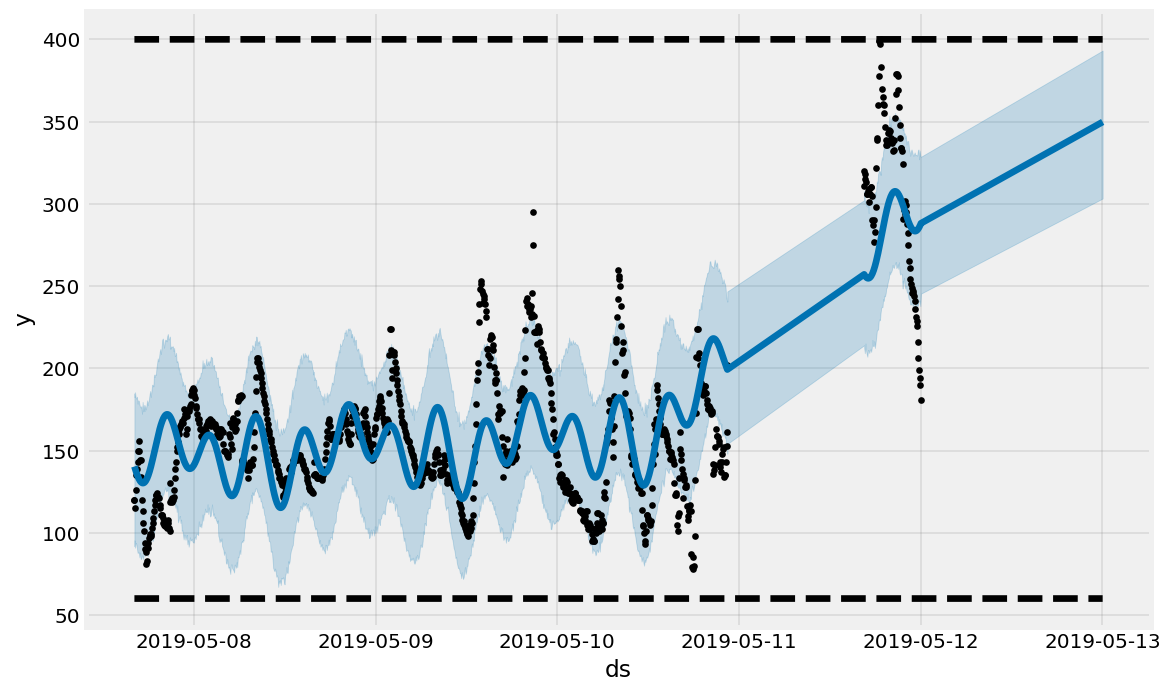

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig1 = m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast)

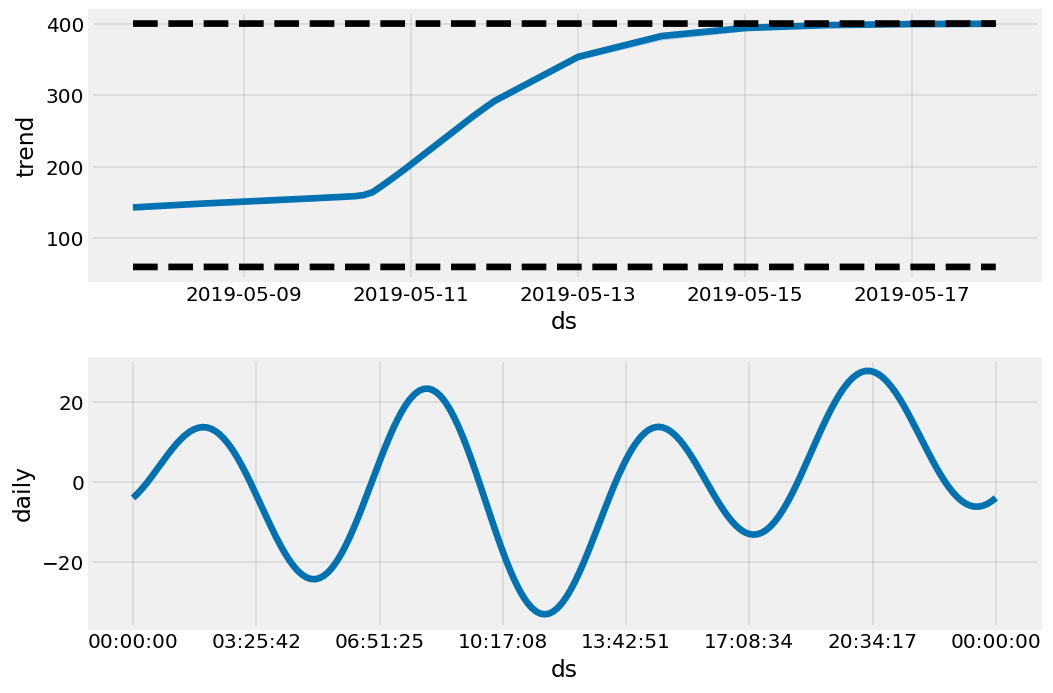

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from fbprophet import Prophet
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(df)

In [ ]:
future_data = prophet.make_future_dataframe(periods=6, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds        yhat    yhat_lower    yhat_upper
1046 2019-05-14 00:02:33 -424.925066  -3679.631408   2916.660137
1047 2019-05-15 00:02:33  833.818543 -12025.729702  13423.681878
1048 2019-05-16 00:02:33 -385.932442 -10803.176341   9971.310337
1049 2019-05-17 00:02:33 -559.270080 -25039.273229  22470.417133
1050 2019-05-18 00:02:33 -467.865375 -30928.513036  28409.068548

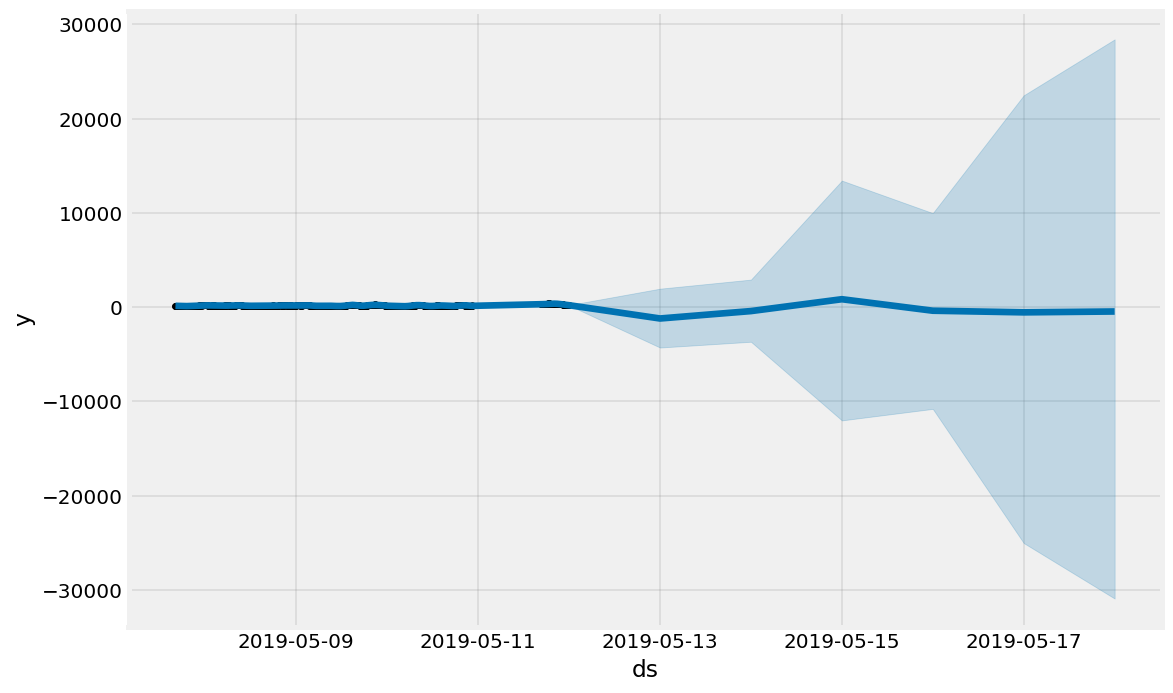

In [ ]:
fig1 = prophet.plot(forecast_data)

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [215]:
import numpy as np
import tensorflow as tf
import random as rn

In [174]:
pip install pykalman

     |████████████████████████████████| 235kB 4.3MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp37-none-any.whl size=48464 sha256=344e51c76cc9181dc341e1c9118f9f69606259bc0b51701914c8b7ddc6cbd4b1
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [216]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [217]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [218]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

## 15분

In [213]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [214]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

In [175]:
from pykalman import KalmanFilter

def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state

In [176]:
def Kalman1D_plot(observations,damping=1):
    # To return the plot
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    plt.plot(pred_state)
    plt.plot(observations,linestyle='--',color='grey',linewidth=0.5)

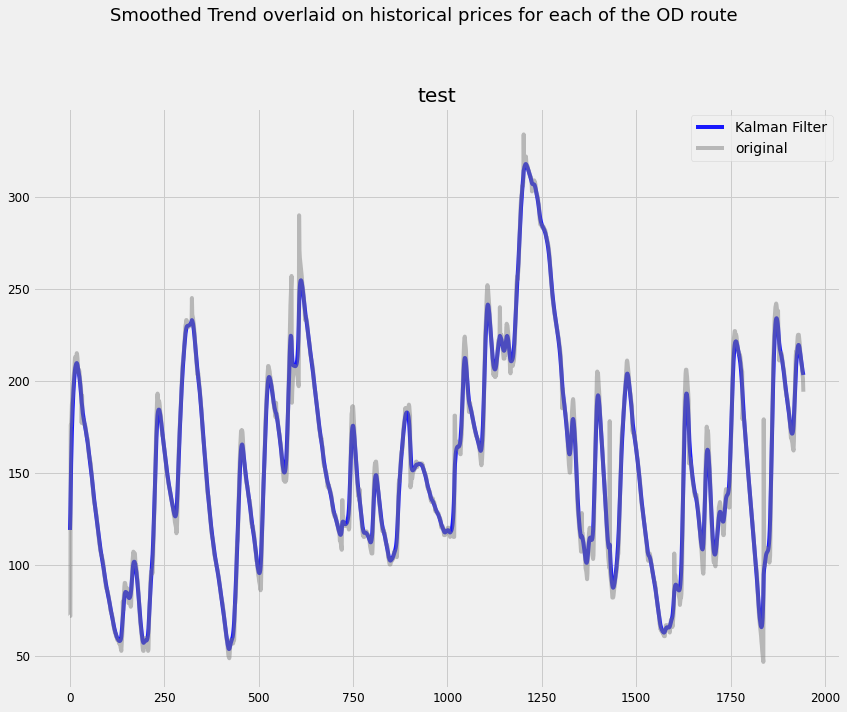

In [212]:
#fig, ax = plt.subplots((N//2), 2, figsize=(15,12))
observations = df['Glucose']
smoothed = Kalman1D(observations.values)
plt.figure(figsize=(12,9))
plt.plot(smoothed,color='blue',alpha=0.9,label='Kalman Filter')

plt.plot(observations.values,color='grey',alpha=0.5,label='original')
plt.title('test')
plt.suptitle('Smoothed Trend overlaid on historical prices for each of the OD route',y=1.1,size=18)
plt.legend(loc='best')
plt.tight_layout()
    

In [220]:
# SG필터 테스트 
#import scipy.signal 

yhat = smoothed
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [221]:
# SG필터 적용하는 부분 
# x_train_uni_origin 이런 식이었음 
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [222]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [ ]:
#x_train_uni.shape

(728, 3, 1)

In [ ]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=3
#uni_future_target=2 # 이거 -1이면 naive method 
#x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)

In [ ]:
#x_train_uni[:10]

In [ ]:
#y_train_uni_origin[:10]

In [ ]:
#y_train_uni.shape

In [ ]:
#x_train_uni[2]

In [ ]:
#y_train_uni[2]

In [ ]:
#df['Glucose'].head(10)

### RNN - 15분

In [240]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [241]:
from keras.layers import SimpleRNN

In [242]:
n_steps = 3
#delay=3
n_features=1

In [243]:
x_train_uni.shape[-2:]

(6, 1)

In [244]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)


In [245]:
K.set_session(sess)

In [246]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [247]:
model.compile(optimizer='adam',loss='mse')

In [248]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [249]:
K.clear_session()

In [250]:
predict_result = model.predict(x_val_uni,verbose=0)

In [251]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [252]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_15 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  7.716376822383921


#### Validation

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


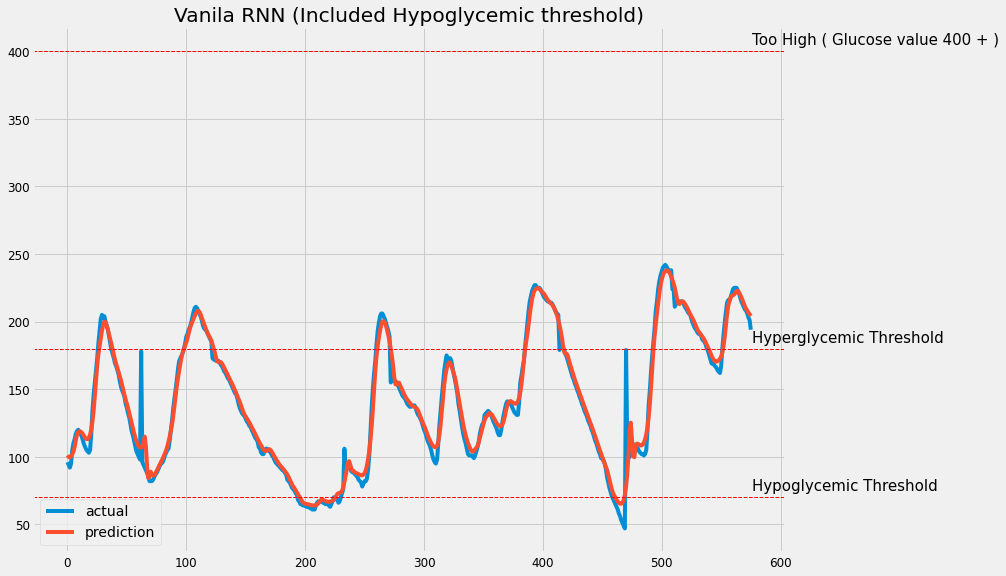

In [236]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [237]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

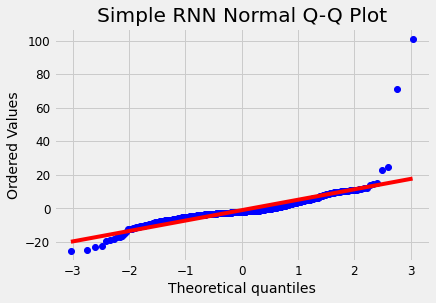

In [238]:
residuals = [y_val_uni_origin[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni_origin - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

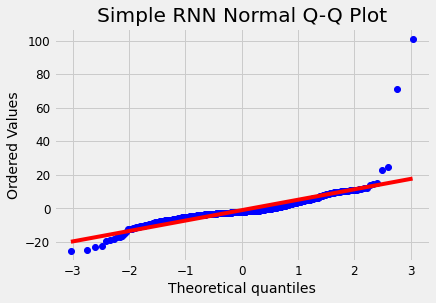

In [239]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [ ]:
residuals=DataFrame(residuals)

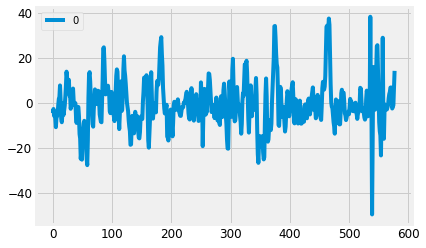

In [ ]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f332b96c4e0>]],
      dtype=object)

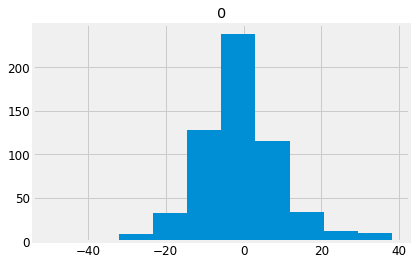

In [ ]:

residuals.hist()

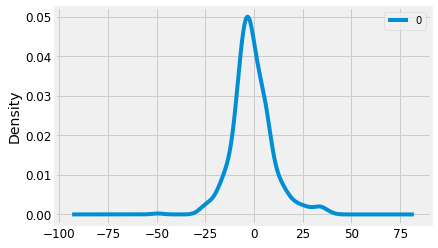

In [ ]:
residuals.plot(kind='kde')

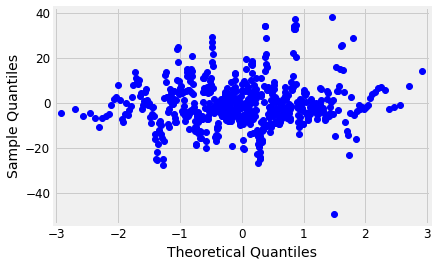

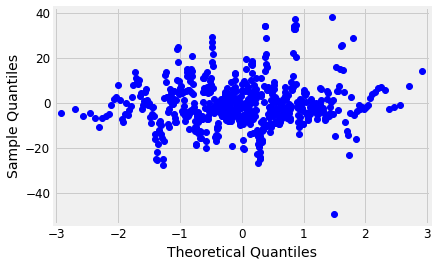

In [ ]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [ ]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_15=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  10.230106123274261


#### Train

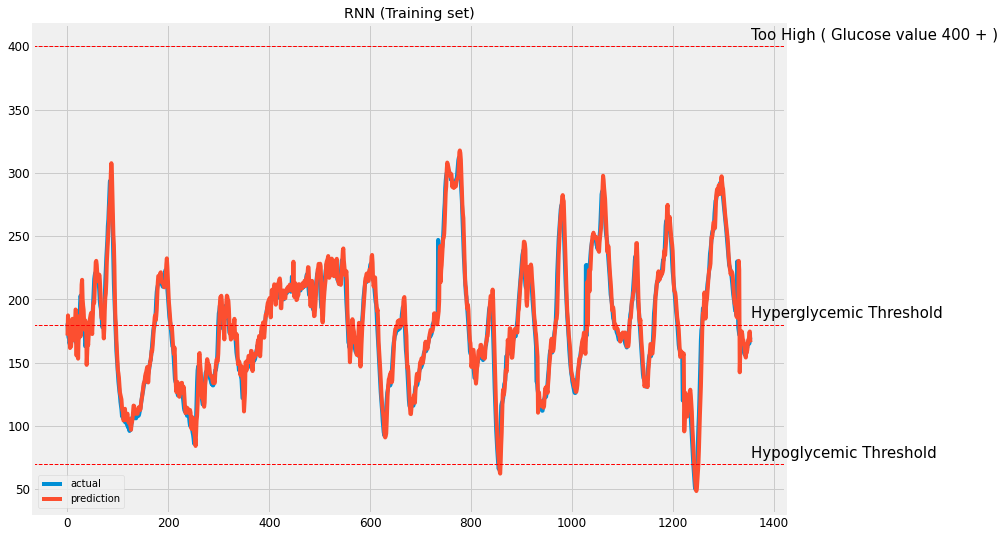

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

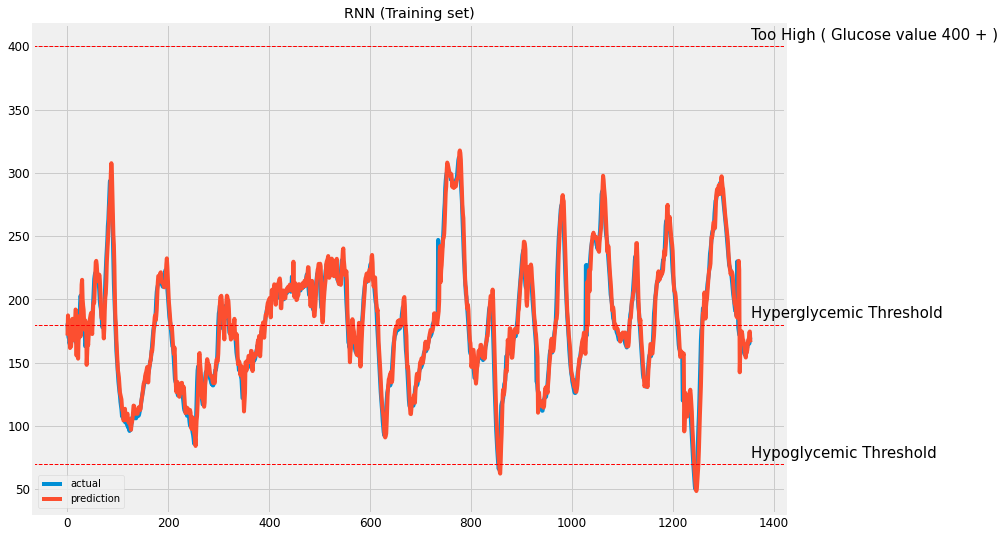

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [ ]:
#predict_result

In [ ]:
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_15=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  11.195589977471577


In [ ]:
TRAIN_SPLIT

1359

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

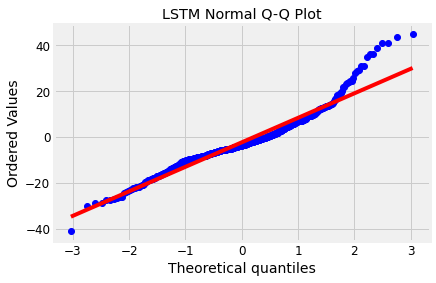

In [ ]:
residuals = [y_val_uni_origin[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni_origin - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

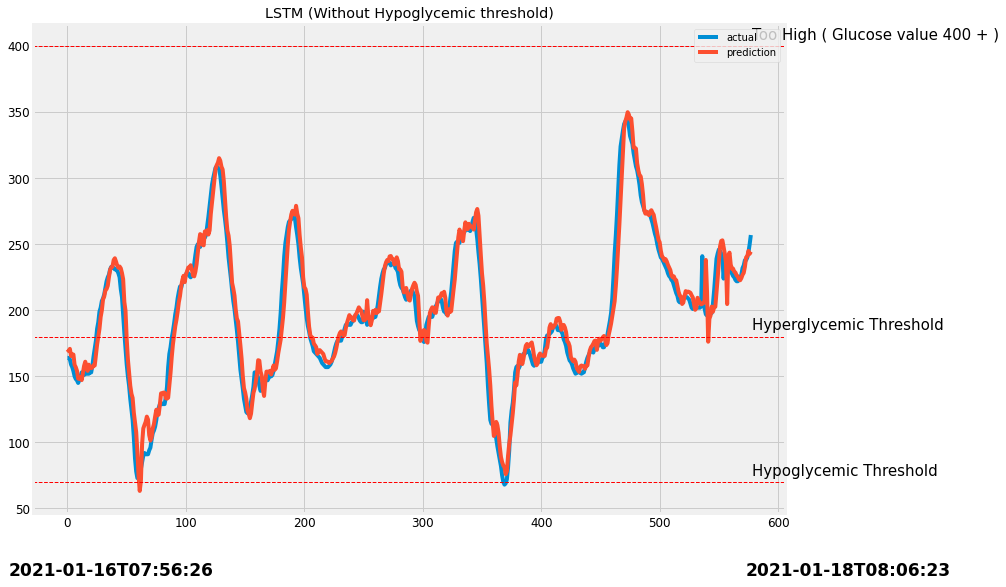

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_15 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  10.200158764358987


#### Train

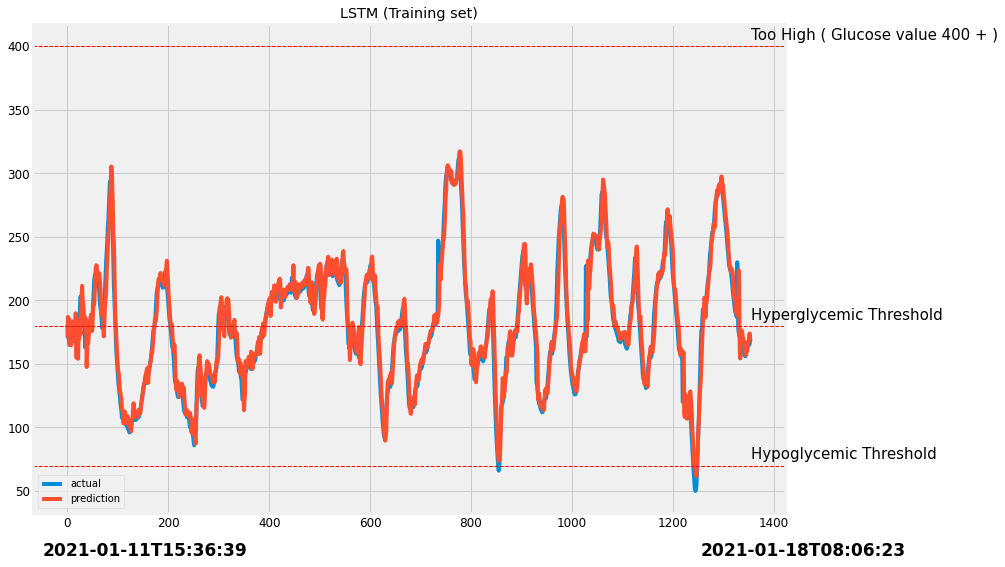

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)


In [ ]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [ ]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_15 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  10.984629490328787


#### Validation

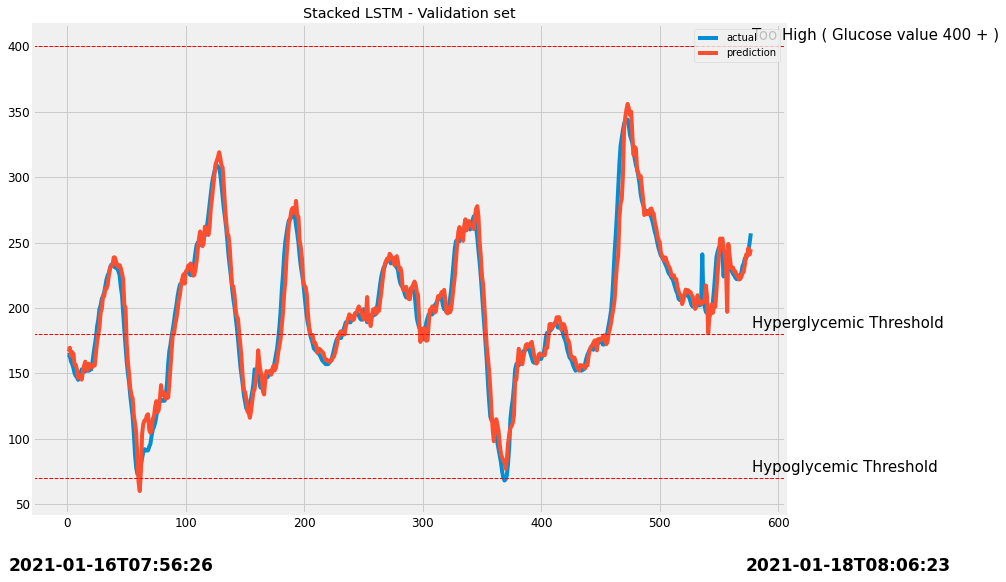

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

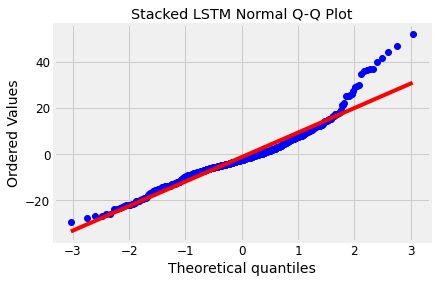

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  9.674557153941034


#### Train

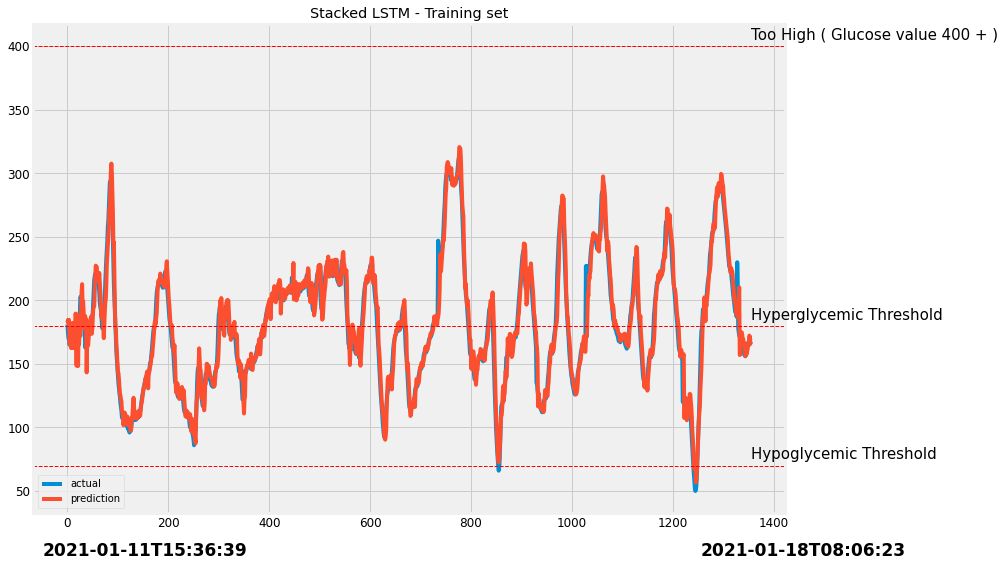

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [ ]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_15 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  10.188310814458493


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

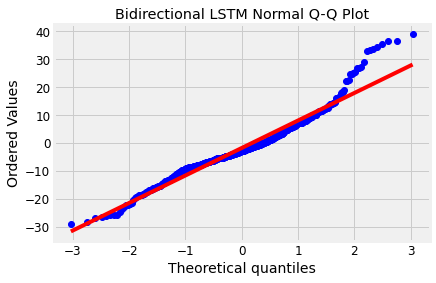

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

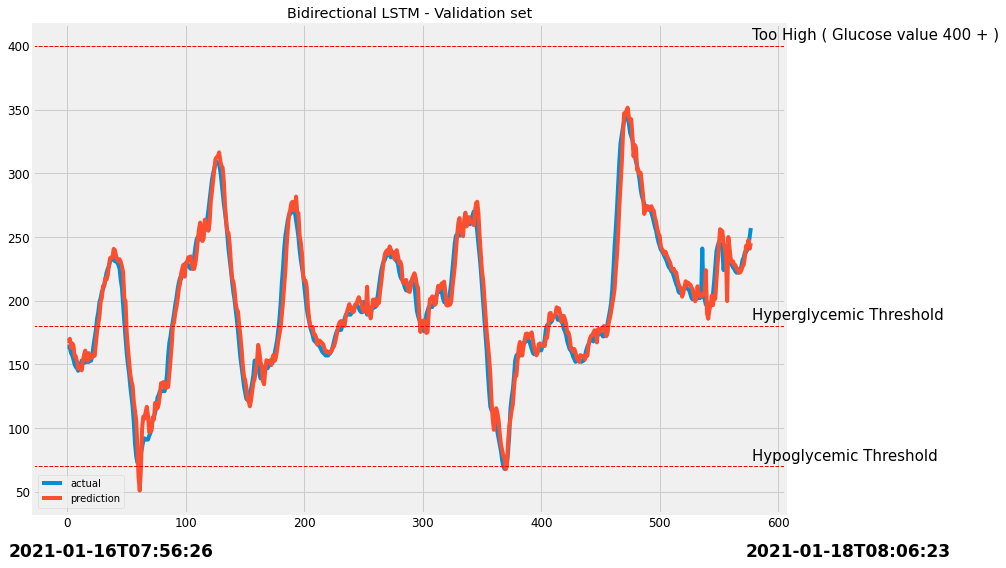

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  9.573507690014118


#### Train

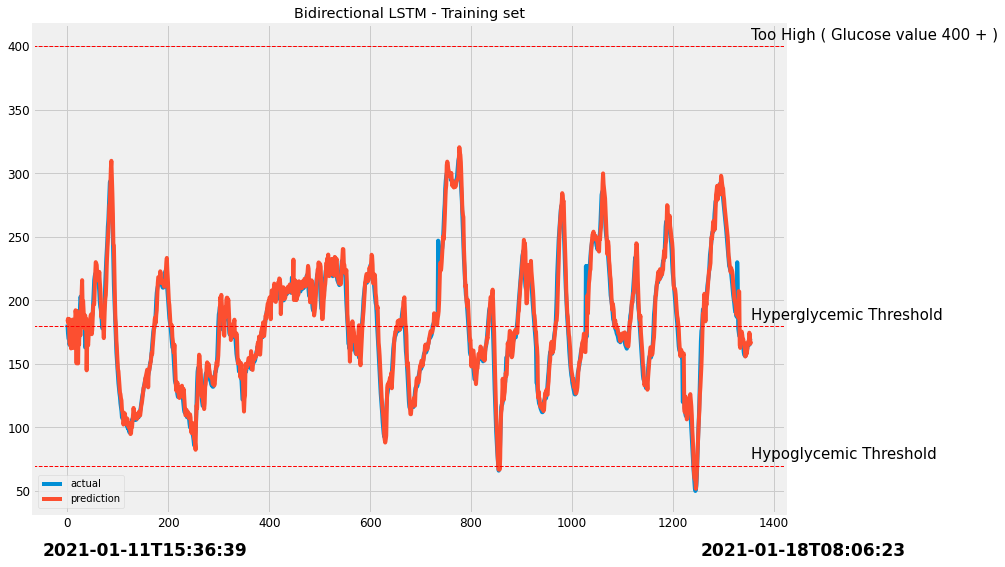

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [ ]:
#predict_result

In [ ]:
#predict_result

In [ ]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_15 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  10.750401196475535


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

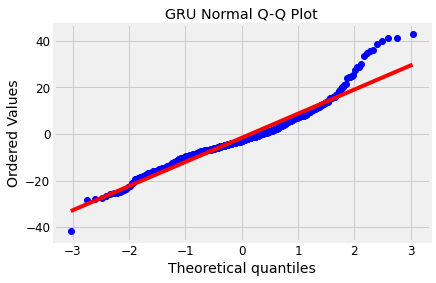

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

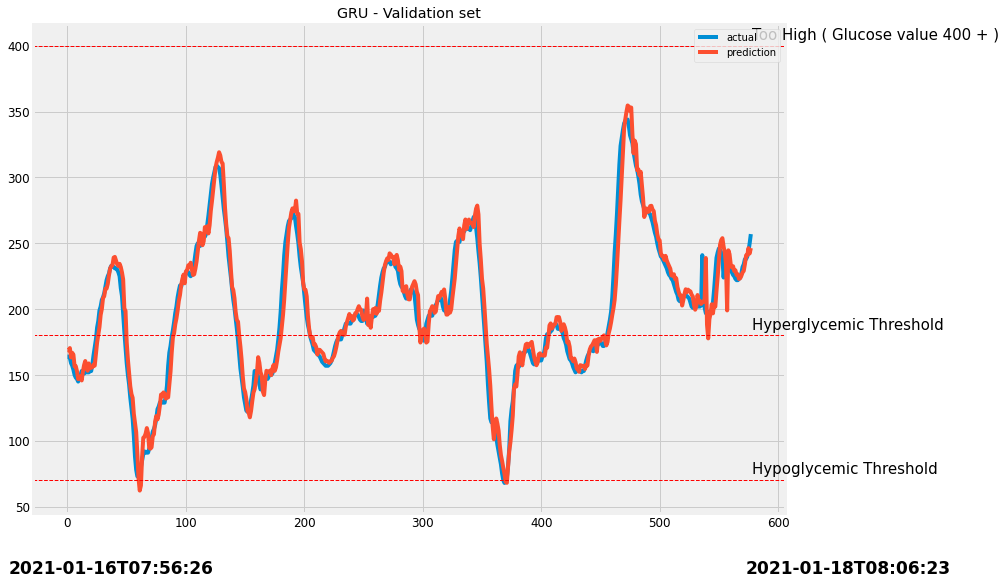

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_15 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  9.933060174023673


#### Train

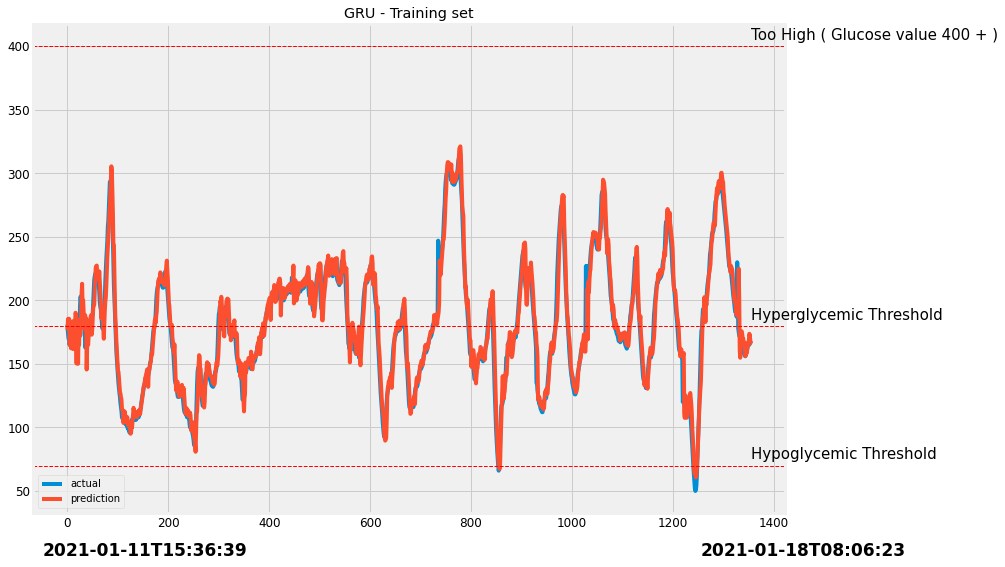

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [ ]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [ ]:
#residuals.plot(kind='kde')

In [ ]:
#residuals.plot()

In [ ]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

## 30분

In [ ]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [ ]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=5
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=3
uni_future_target=5
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=3
uni_future_target=5
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [ ]:
x_train_uni.shape


(1356, 3, 1)

In [ ]:

x_val_uni.shape

(575, 3, 1)

In [ ]:
x_train_uni[0]

array([[204],
       [177],
       [181]])

In [ ]:
df['Glucose'].head(15)

0     204.0
1     177.0
2     181.0
3     181.0
4     180.0
5     181.0
6     174.0
7     170.0
8     169.0
9     165.0
10    167.0
11    170.0
12    175.0
13    168.0
14    171.0
Name: Glucose, dtype: float64

In [ ]:
y_train_uni[0]

169

### RNN - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

In [ ]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [ ]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_30 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  21.951296761636332


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

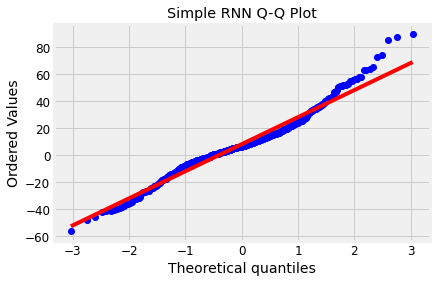

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

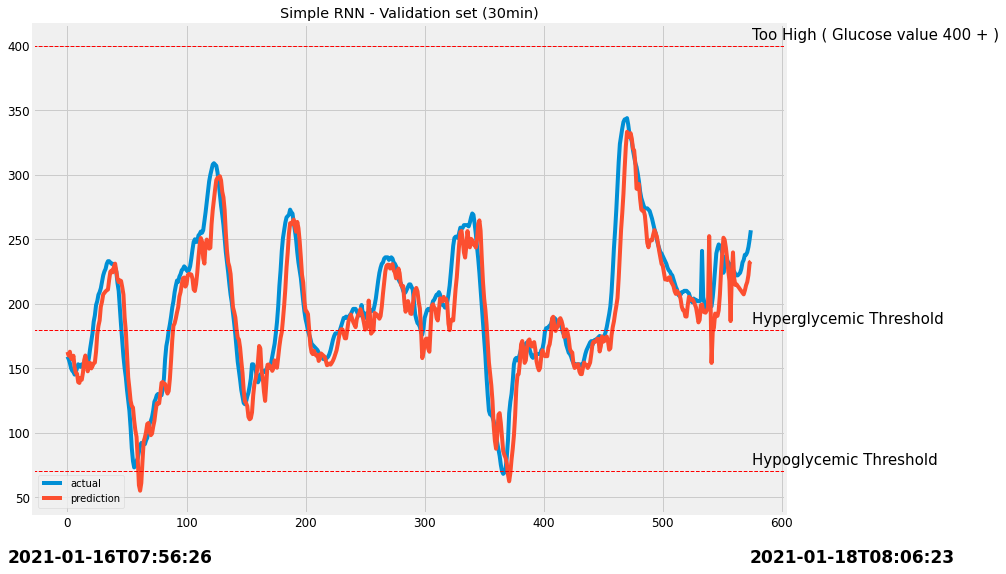

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

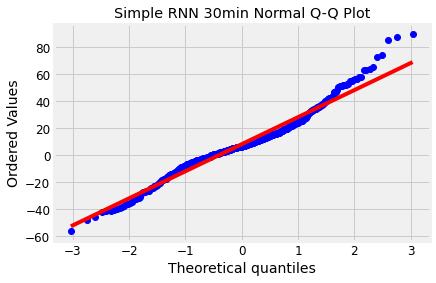

In [ ]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [ ]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_30=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  19.42936056780985


#### Train

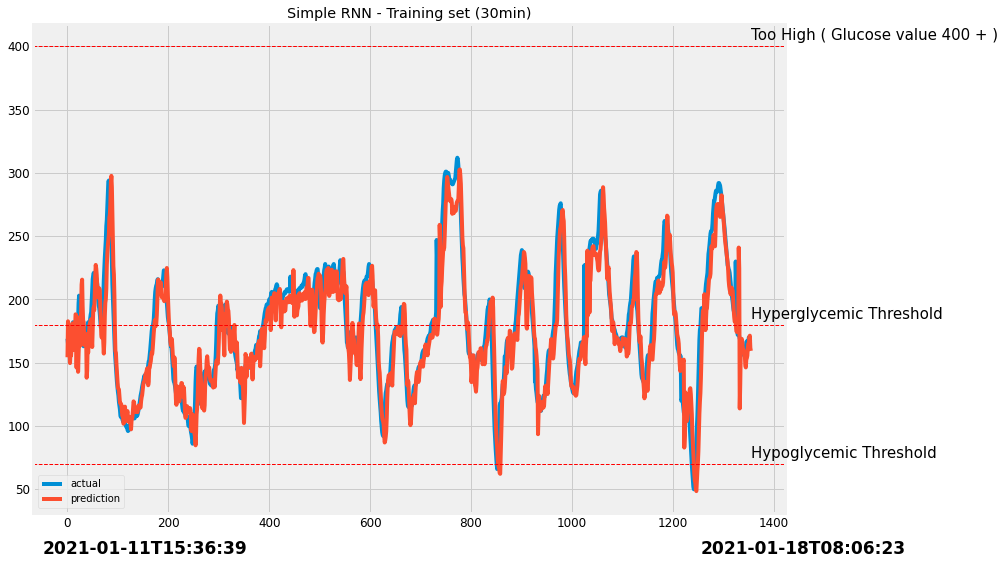

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_30=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  21.688317061948524


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

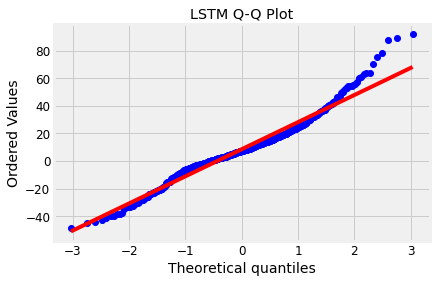

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

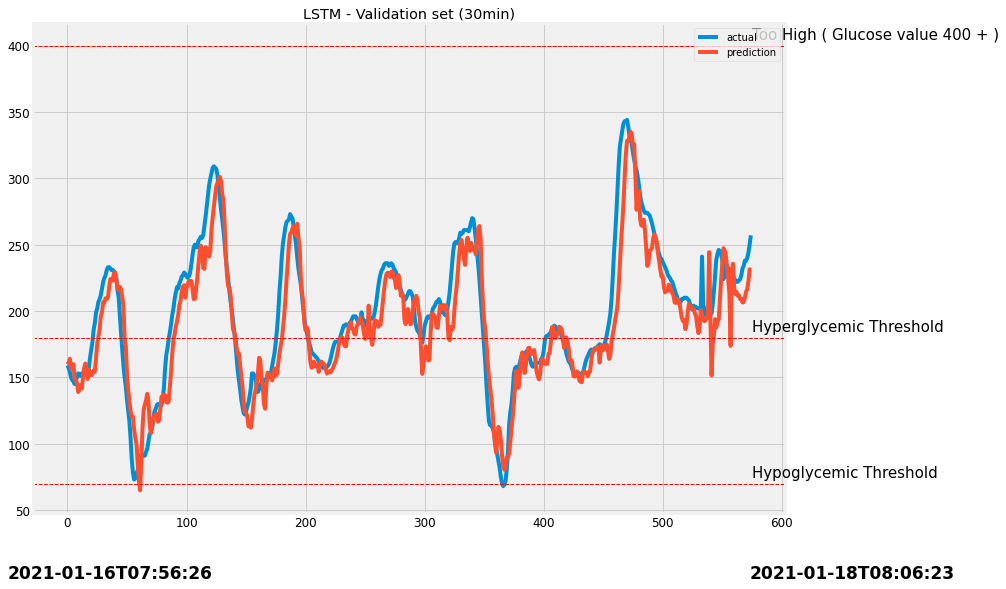

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_30 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  18.655995615401537


#### Train

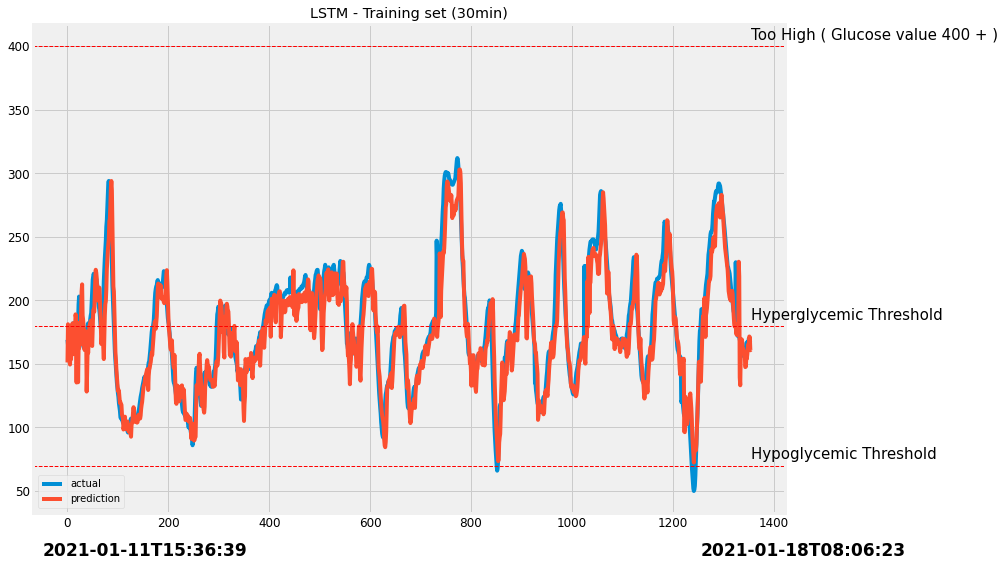

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_30 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  21.773937162183962


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

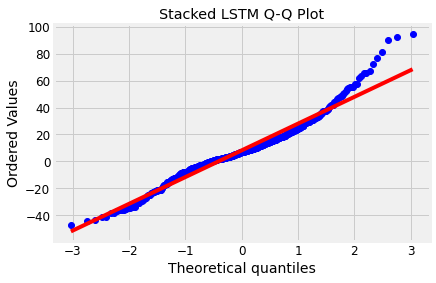

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

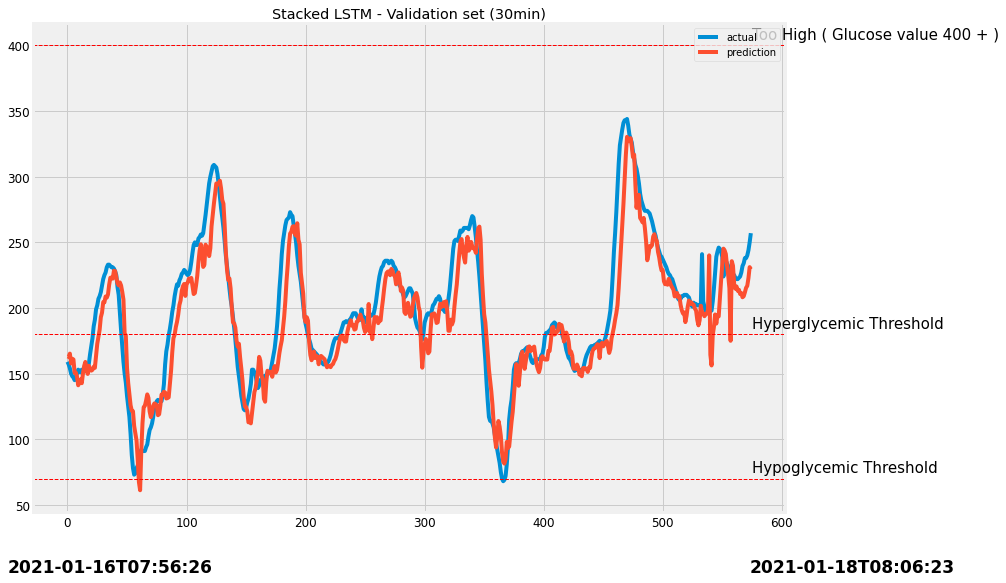

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  18.591365015634157


#### Train

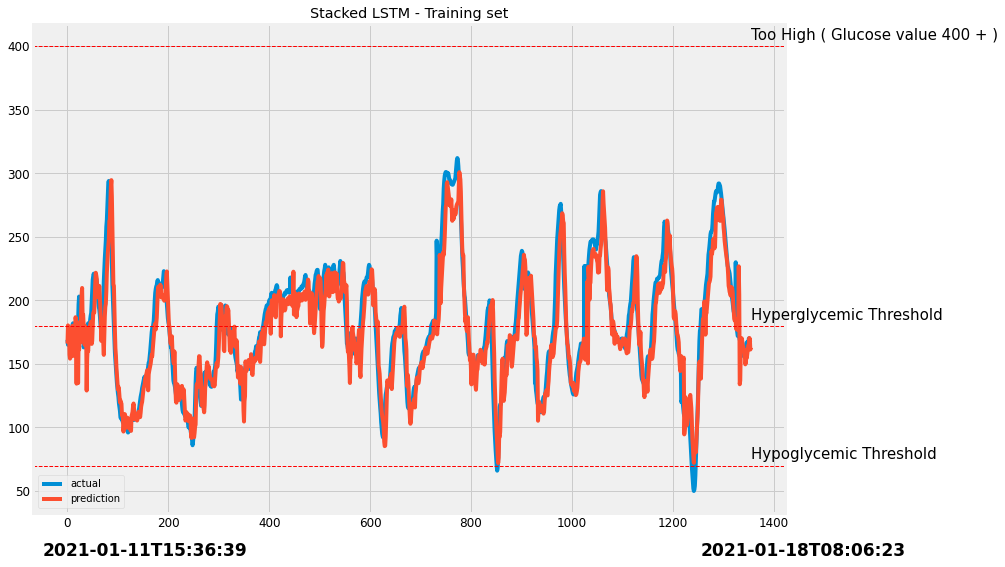

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_30 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  20.488741740308857


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

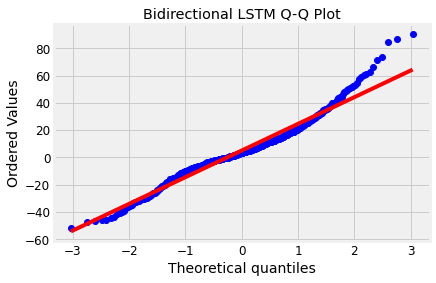

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

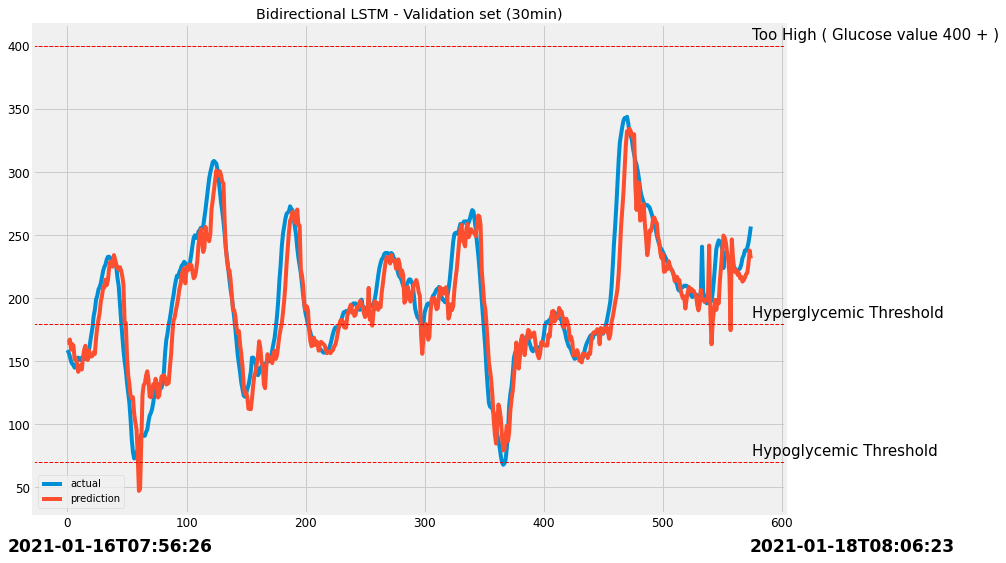

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  17.409019907758378


#### Train

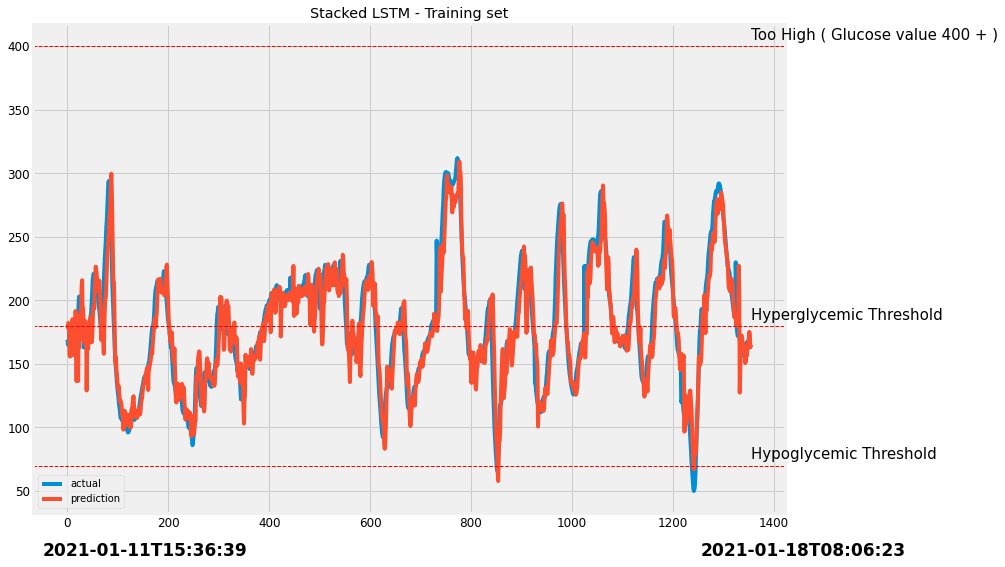

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  22.41924733448097


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

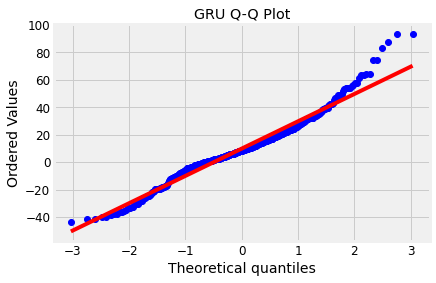

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

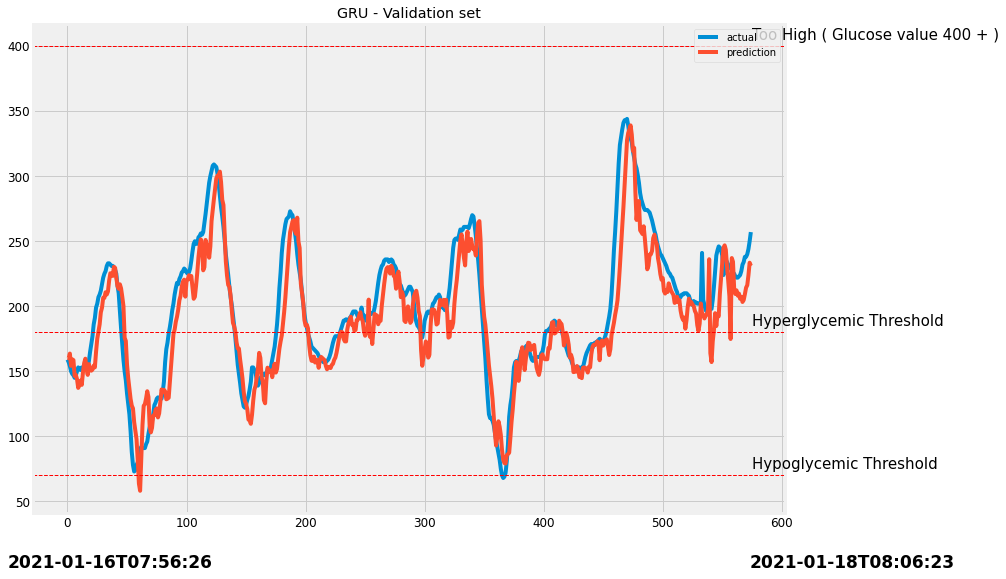

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_30 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  18.92483605443343


#### Train

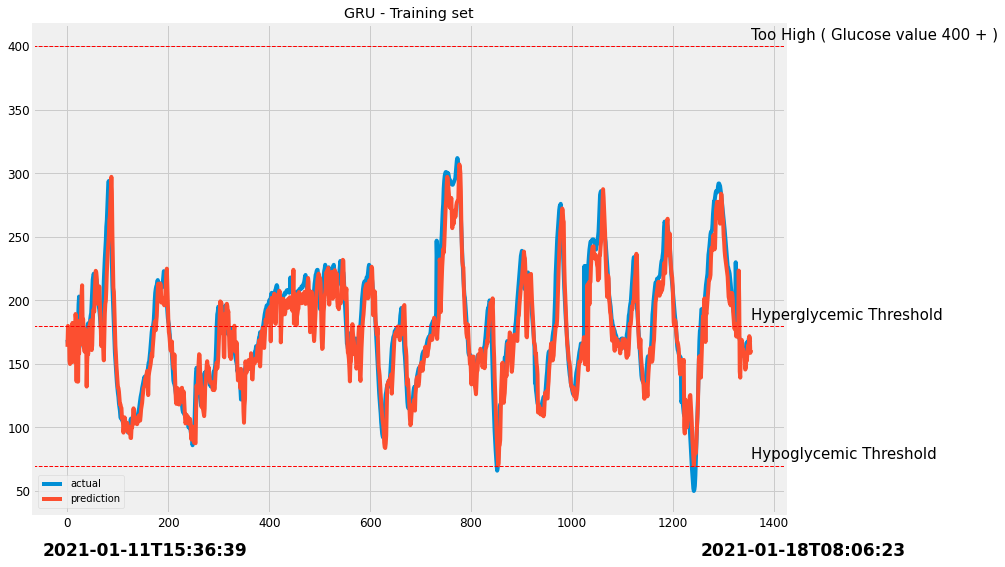

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [ ]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [ ]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=11
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=3
uni_future_target=11
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [ ]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=3
uni_future_target=11
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [ ]:
x_train_uni[0]

array([[204],
       [177],
       [181]])

In [ ]:
y_train_uni[0]

171

In [ ]:
df['Glucose'].head(20)

0     204.0
1     177.0
2     181.0
3     181.0
4     180.0
5     181.0
6     174.0
7     170.0
8     169.0
9     165.0
10    167.0
11    170.0
12    175.0
13    168.0
14    171.0
15    170.0
16    171.0
17    174.0
18    181.0
19    182.0
Name: Glucose, dtype: float64

### RNN - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [ ]:
K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_60 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  38.35099456163501


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

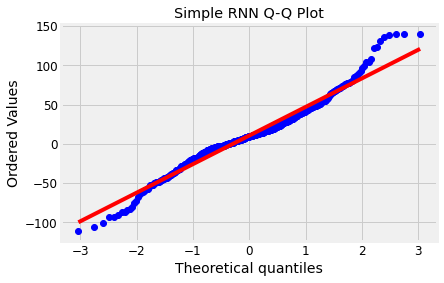

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

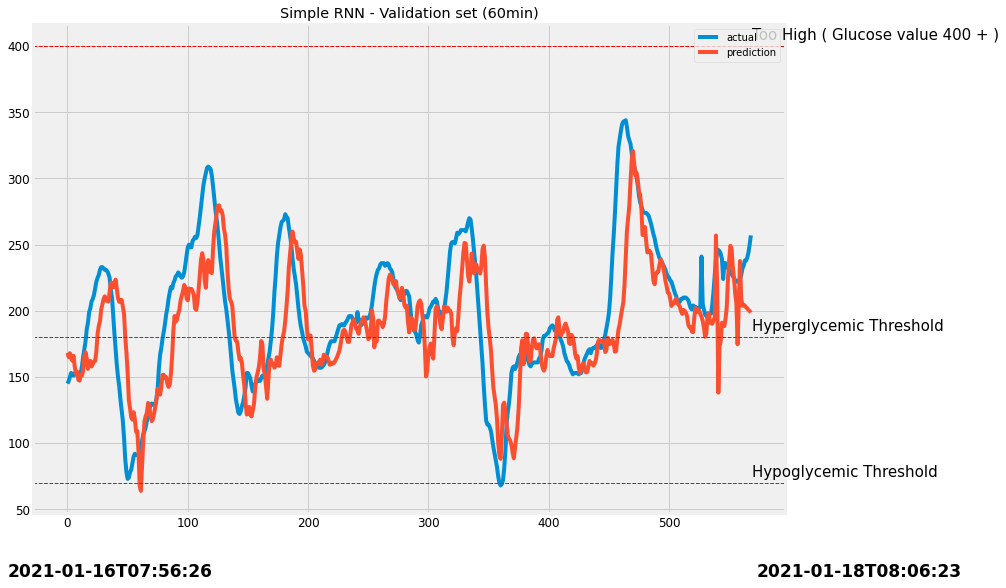

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

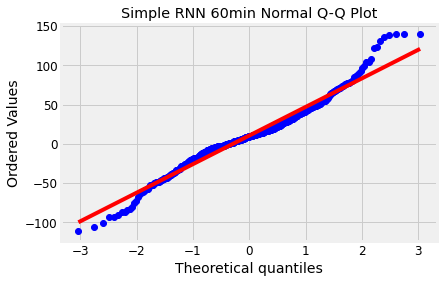

In [ ]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [ ]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_60=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  32.45845118196221


#### Train

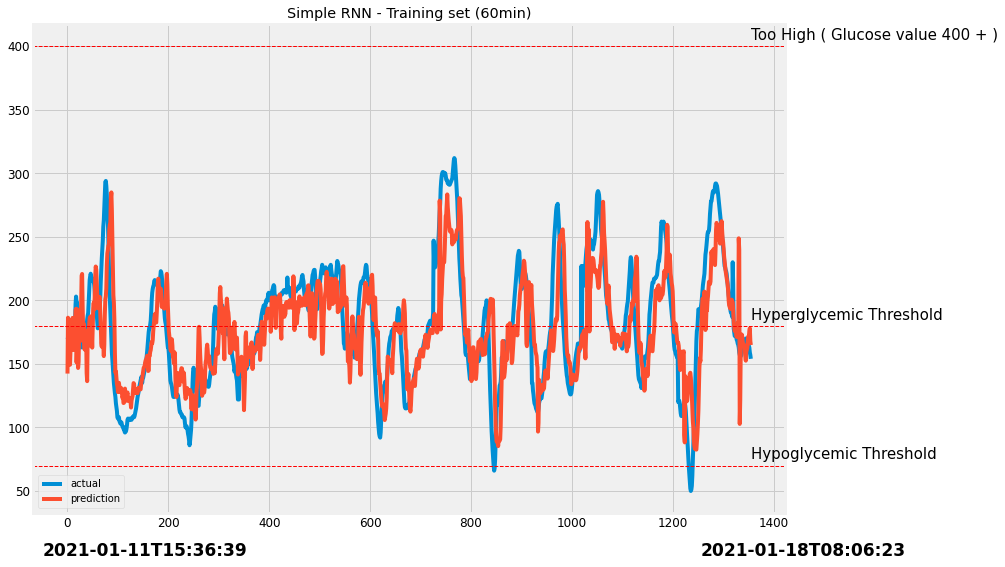

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_60=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (60min) :  38.22538311233257


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

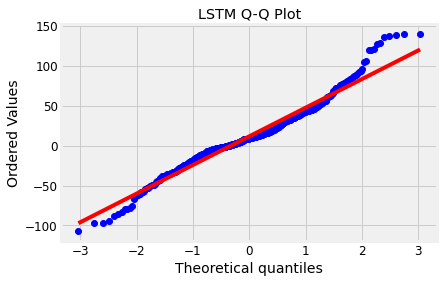

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

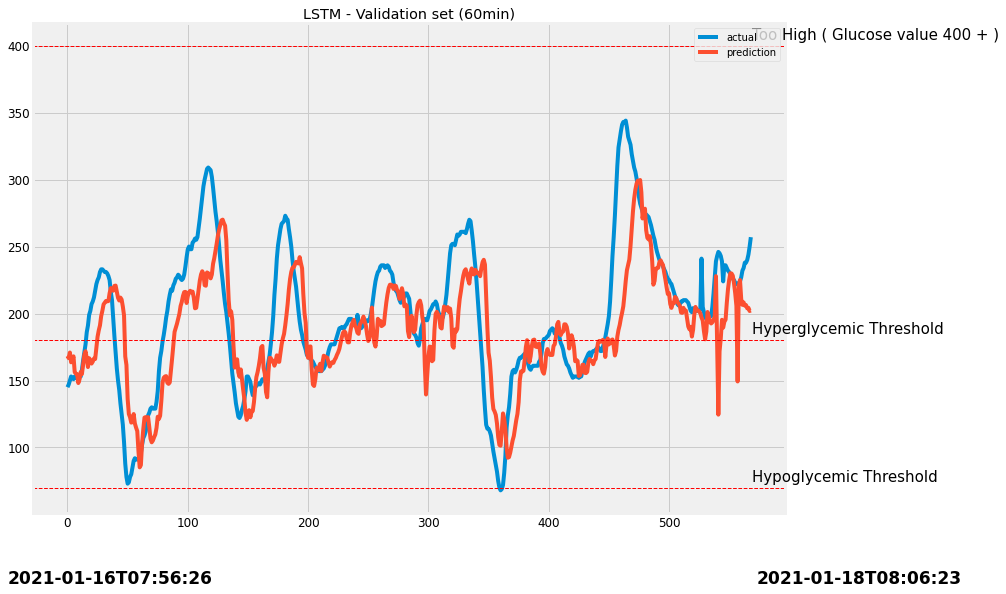

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_60 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (60min) Training set :  31.040650068114495


#### Train

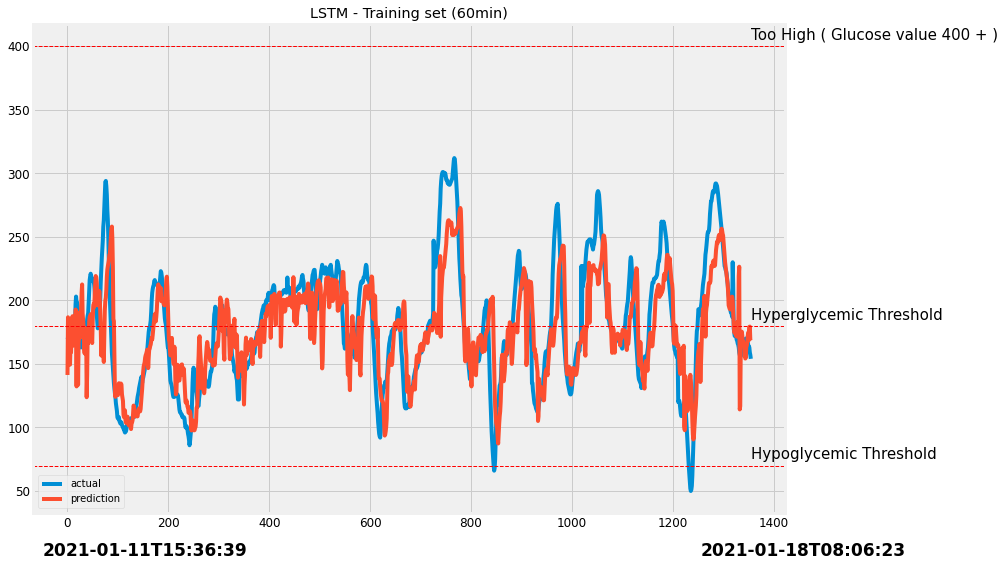

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_60 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  37.29238092237771


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

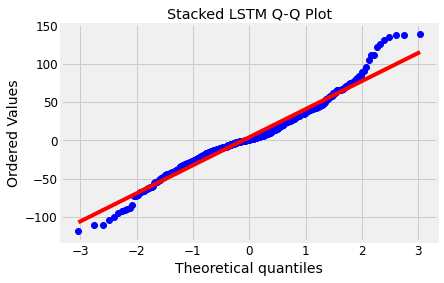

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

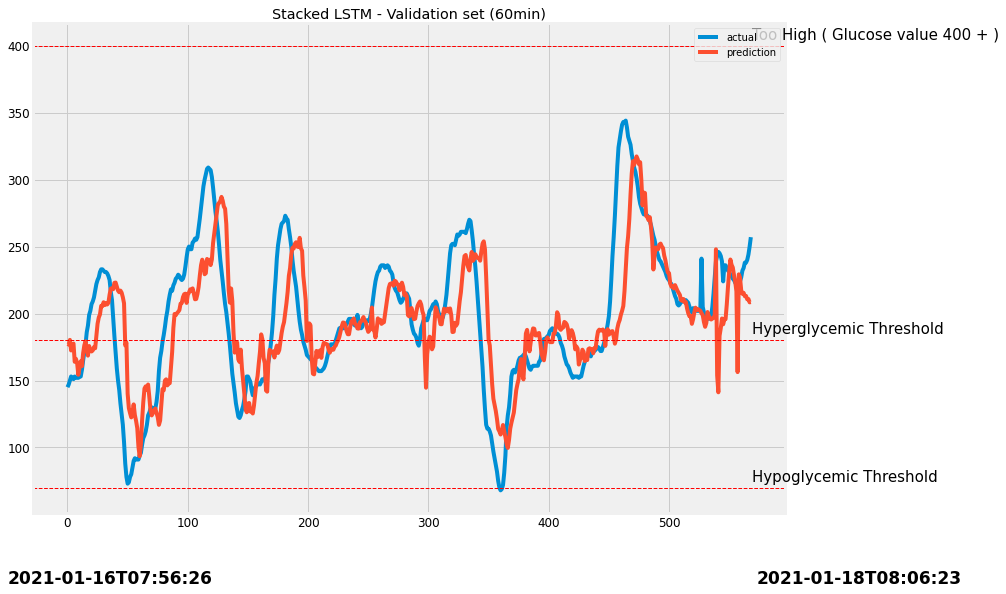

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (60min) Training set :  30.810961861789227


#### Train

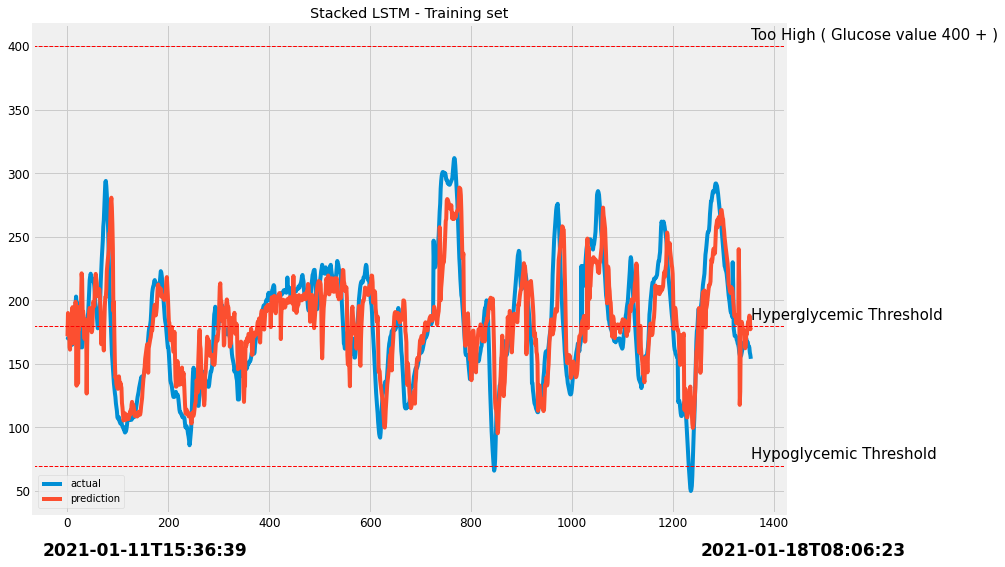

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_60 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  36.86406234923679


#### Validation

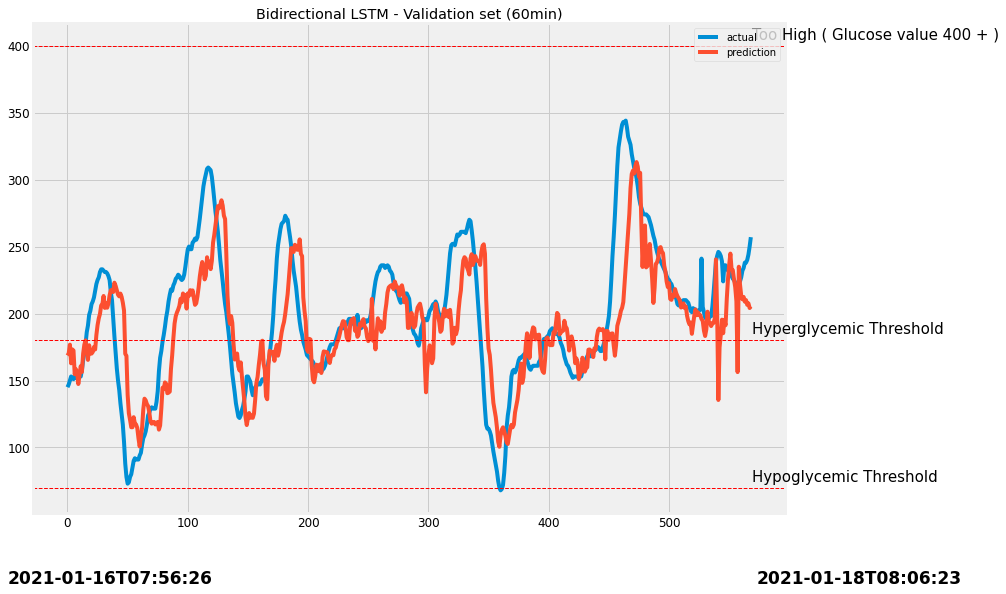

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

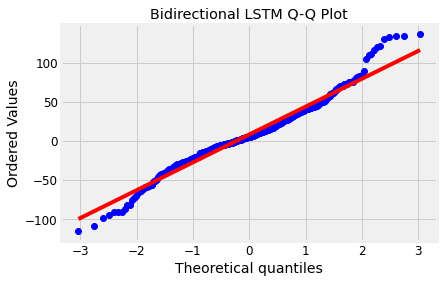

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  30.067772855615786


#### Train

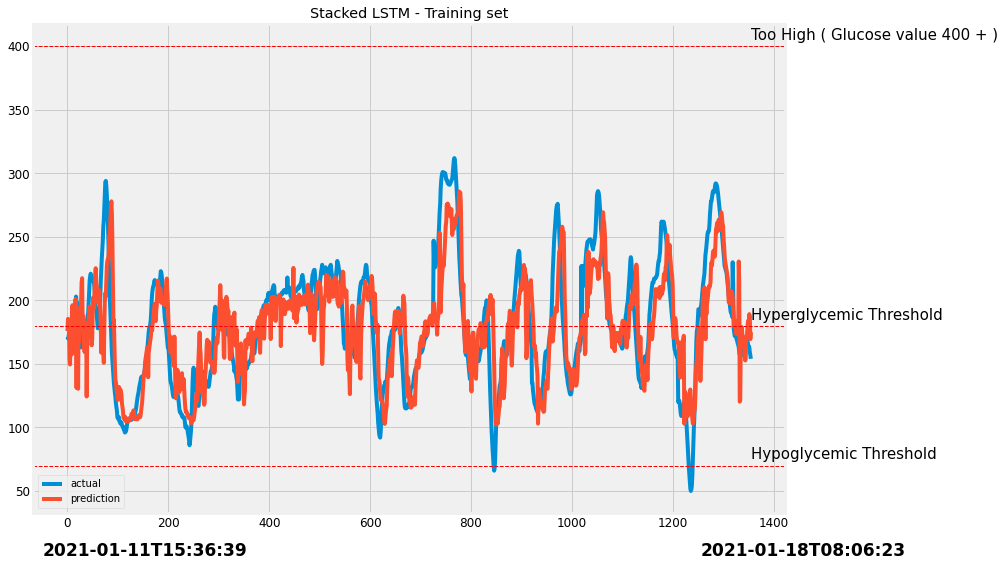

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [ ]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [ ]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_60 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  37.142912187513815


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

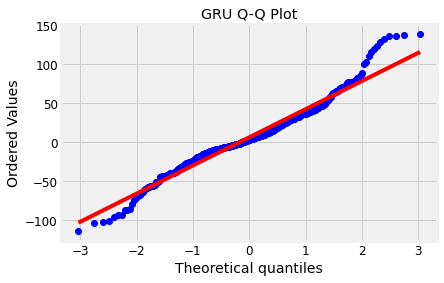

In [ ]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

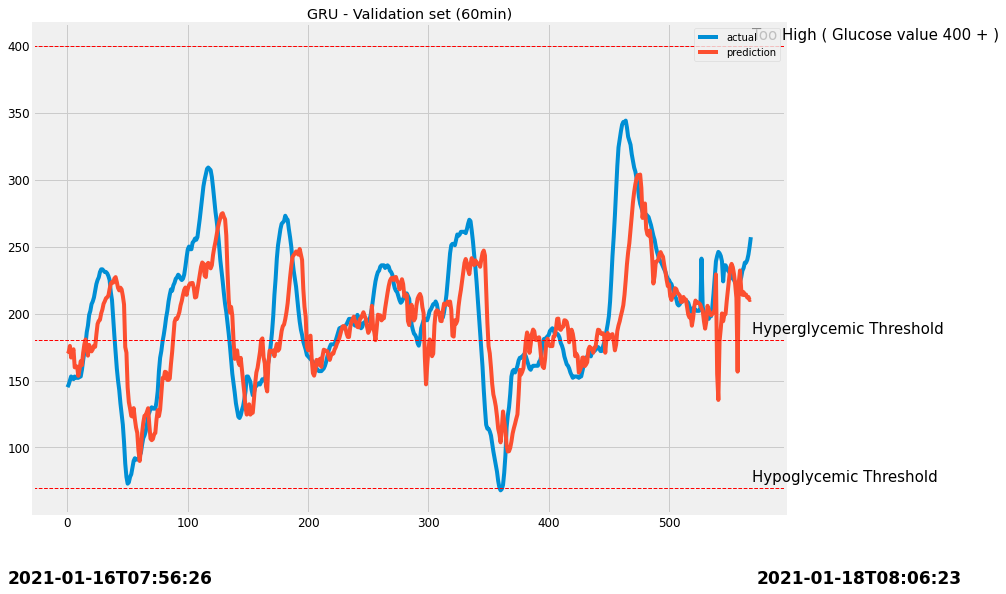

In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [ ]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_60 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (60min) Training set :  30.730689027232984


#### Train

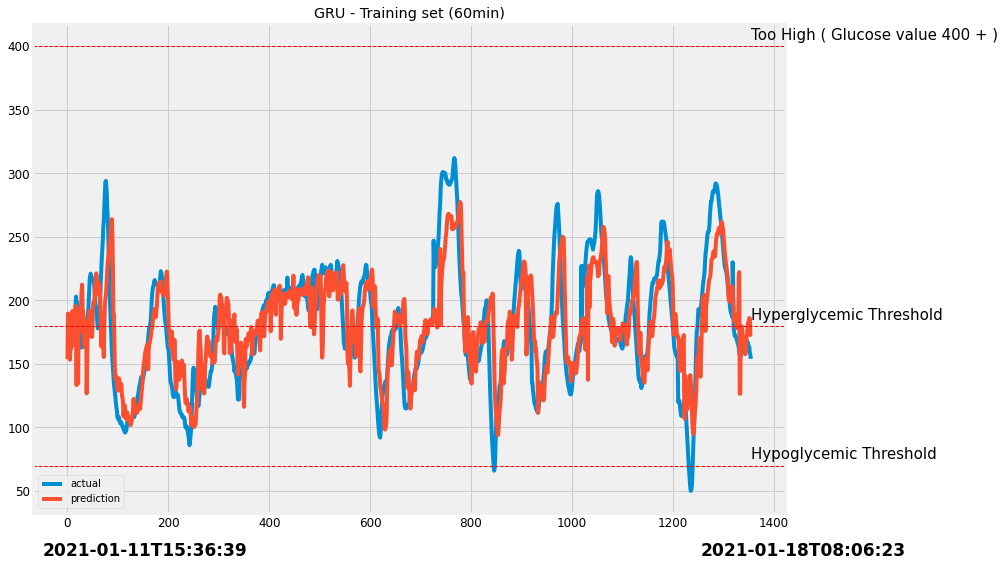

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 결과

In [ ]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60]


In [ ]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]

In [ ]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [ ]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result]

In [ ]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result]

In [ ]:
val_result_list

[[10.35718056585939, 21.951296761636332, 38.35099456163501],
 [11.195589977471577, 21.688317061948524, 38.22538311233257],
 [10.984629490328787, 21.773937162183962, 37.29238092237771],
 [10.188310814458493, 20.488741740308857, 36.86406234923679],
 [10.750401196475535, 22.41924733448097, 37.142912187513815]]

In [ ]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

15 MIN     30 MIN     60 MIN
RNN                 10.357181  21.951297  38.350995
LSTM                11.195590  21.688317  38.225383
Stacked LSTM        10.984629  21.773937  37.292381
Bidirectional LSTM  10.188311  20.488742  36.864062
GRU                 10.750401  22.419247  37.142912

In [ ]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

15 MIN     30 MIN     60 MIN
RNN                 10.230106  19.429361  32.458451
LSTM                10.200159  18.655996  31.040650
Stacked LSTM         9.674557  18.591365  30.810962
Bidirectional LSTM   9.573508  17.409020  30.067773
GRU                  9.933060  18.924836  30.730689

## CNN LSTM